# Cytotoxic CD4+ cells

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import glob

import pertpy

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/

In [3]:
DATADIR="/mnt/oak/users/emma/data/GWT/"
os.makedirs('/mnt/oak/users/emma/data/GWT/cytotoxic_CD4_data/', exist_ok=True)

## Process TIL data

In [4]:
!wget "https://www.ncbi.xyz/geo/download/?acc=GSE293860&format=file" -O GSE293860_data.tar

--2025-06-13 08:29:04--  https://www.ncbi.xyz/geo/download/?acc=GSE293860&format=file
Resolving www.ncbi.xyz (www.ncbi.xyz)... 152.70.254.62
Connecting to www.ncbi.xyz (www.ncbi.xyz)|152.70.254.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Cookie coming from www.ncbi.xyz attempted to set domain to nih.gov
Length: 342968320 (327M) [application/x-tar]
Saving to: ‘GSE293860_data.tar’

GSE293860_data.tar  100%[===================>] 327.08M  1.65MB/s    in 94s     

2025-06-13 08:30:39 (3.49 MB/s) - ‘GSE293860_data.tar’ saved [342968320/342968320]



In [5]:
!tar -xf GSE293860_data.tar -C /mnt/oak/users/emma/data/GWT/cytotoxic_CD4_data/

In [5]:
# Cell annotation from Cell2020 study
!curl -o CD4_TIL_cellinfo.csv.gz "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149652/suppl/GSE149652%5FCD4%5FTIL%5Fdroplet%5Fcellinfo%5Fmatrice.csv.gz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  577k  100  577k    0     0  1082k      0 --:--:-- --:--:-- --:--:-- 1083k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 66.5M  100 66.5M    0     0  12.9M      0  0:00:05  0:00:05 --:--:-- 15.1M


In [93]:
import pandas as pd
import anndata as ad
import scanpy as sc
import numpy as np
from pathlib import Path
import re
import glob

def format_sample_name(metadata):
    """Format sample name in human readable format."""
    treatment = metadata['treatment']
    patient_id = metadata['patient_id']
    tissue = metadata['tissue']
    
    # Format treatment
    if treatment == 'anti_pdl1':
        treatment_str = 'Anti-PD-L1'
    elif treatment == 'chemo':
        treatment_str = 'Chemo'
    elif treatment == 'untreated':
        treatment_str = 'Untreated'
    else:
        treatment_str = treatment.capitalize()
    
    # Format patient ID
    if treatment == 'chemo':
        patient_str = ''
    else:
        patient_str = f' {patient_id.upper()}'
    
    # Format tissue
    tissue_str = tissue
    
    # Combine parts
    formatted_name = f"{treatment_str}{patient_str} {tissue_str} CD4"
    
    return formatted_name

def parse_sample_metadata(filename):
    """Extract sample metadata from filename."""
    # Example filename: GSM8892064_anti_pdl1_a_tumor_cd4_barcodes.tsv.gz
    parts = filename.split('_')
    
    metadata = {}
    metadata['GSM_id'] = parts[0]
    
    # Extract treatment
    if 'anti_pdl1' in filename:
        metadata['treatment'] = 'anti_pdl1'
        metadata['patient_id'] = parts[3]  # a, b, c, d, e
    elif 'chemo' in filename:
        metadata['treatment'] = 'chemo'
        metadata['patient_id'] = 'chemo_patient'
    elif 'healthy' in filename:
        metadata['treatment'] = 'healthy'
        metadata['patient_id'] = parts[3]  # replicate1, replicate2, replicate3
    elif 'untreated' in filename:
        metadata['treatment'] = 'untreated'
        metadata['patient_id'] = parts[2]  # a, b
    else:
        metadata['treatment'] = 'unknown'
        metadata['patient_id'] = 'unknown'
    
    # Extract tissue type
    if 'tumor' in filename:
        metadata['tissue'] = 'tumor'
    elif 'normal' in filename:
        metadata['tissue'] = 'normal'
    elif 'blood' in filename:
        metadata['tissue'] = 'blood'
    else:
        metadata['tissue'] = 'unknown'
    
    # Extract timepoint if present
    if 'pre' in filename:
        metadata['timepoint'] = 'pre'
    elif 'post' in filename:
        metadata['timepoint'] = 'post'
    else:
        metadata['timepoint'] = 'baseline'
    
    return metadata



def read_10x_data(data_dir, sample_prefix):
    """Read 10X format data (matrix, barcodes, genes) into AnnData object."""
    
    # File paths
    matrix_file = f"{data_dir}/{sample_prefix}_matrix.mtx.gz"
    barcodes_file = f"{data_dir}/{sample_prefix}_barcodes.tsv.gz"
    genes_file = f"{data_dir}/{sample_prefix}_genes.tsv.gz"
    
    try:
        # Read the data using scanpy
        adata = ad.io.read_mtx(
            matrix_file
        ).T
        
        var_df = pd.read_table(genes_file, compression='gzip', header=None)
        var_df.columns = ['gene_ids', 'gene_name']
        adata.var = var_df
        adata.var_names = adata.var['gene_ids'].values

        obs_df = pd.read_table(barcodes_file, compression='gzip', header=None)
        obs_df.columns = ['barcode']
        adata.obs = obs_df
        adata.obs_names = adata.obs['barcode'].values

        # Extract sample metadata from filename
        metadata = parse_sample_metadata(sample_prefix)
        
        # Add metadata to obs
        for key, value in metadata.items():
            adata.obs[key] = value
        
        # Add sample name
        adata.obs['sample_name'] = sample_prefix
        adata.obs['Sample_ID'] = format_sample_name(metadata)
        return adata
        
    except Exception as e:
        print(e)
        return None

In [94]:
data_dir = "/mnt/oak/users/emma/data/GWT/cytotoxic_CD4_data/"
matrix_files = glob.glob(f"{data_dir}/*cd4_matrix.mtx.gz")

# Filter for tumor and normal samples only (exclude blood)
tumor_normal_files = [f for f in matrix_files 
                        if ('tumor' in f or 'normal' in f) and 'blood' not in f]

# Extract sample prefixes
sample_prefixes = []
for file_path in tumor_normal_files:
    filename = Path(file_path).name
    # Remove '_matrix.mtx.gz' to get prefix
    prefix = filename.replace('_matrix.mtx.gz', '')
    sample_prefixes.append(prefix)

# Read all samples
adata_list = []
for prefix in sample_prefixes:
    adata = read_10x_data(data_dir, prefix)
    if adata is not None:
        adata_list.append(adata)

# Concatenate all samples
if adata_list:
    adata_combined = ad.concat(adata_list, join='outer', index_unique='_')

# Keep gene annotations
adata_combined.var = adata_list[0].var.copy()
adata_combined.obs = adata_combined.obs.drop('patient_id', axis=1)

# Filter cells with cell type annotation from Cell2020 paper
merged_obs_df = pd.read_csv('CD4_TIL_cellinfo.csv.gz', compression='gzip', index_col=0)
merged_obs_df['barcode'] = merged_obs_df.index.str.split("-").str[:-1].str.join('-')
obs_filt = pd.merge(adata_combined.obs.reset_index(), merged_obs_df[['barcode', 'Sample_ID', 'cell_types', 'patient']], on=['barcode', 'Sample_ID'])
obs_filt = obs_filt.set_index('index')
adata = adata_combined[obs_filt.index.tolist()].copy()
adata.obs = obs_filt.copy()
    

In [95]:
adata

AnnData object with n_obs × n_vars = 19842 × 32738
    obs: 'barcode', 'GSM_id', 'treatment', 'tissue', 'timepoint', 'sample_name', 'Sample_ID', 'cell_types', 'patient'
    var: 'gene_ids', 'gene_name'

## DE analysis on cytotoxic CD4 cells

In [96]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.var_names = adata.var['gene_name'].astype(str).copy()
adata.var_names_make_unique()

Option 1 - one-vs-all test

In [100]:
pbulk_adata = sc.get.aggregate(adata, by=['Sample_ID', 'tissue','treatment', 'patient','cell_types'], func=['sum'], layer='counts')
n_cells = adata.obs.groupby(['Sample_ID', 'tissue','treatment', 'patient','cell_types']).size().reset_index().rename({0:'n_cells'}, axis=1)

obs_df = pd.merge(pbulk_adata.obs, n_cells)
obs_df.index = pbulk_adata.obs_names.copy()
pbulk_adata.obs = obs_df.copy()
pbulk_adata = pbulk_adata[pbulk_adata.obs['n_cells'] >= 3].copy()

pbulk_adata.obs['total_counts'] = pbulk_adata.layers['sum'].sum(axis=1)

# HVGs
pbulk_adata.X = pbulk_adata.layers['sum'].copy()
sc.pp.normalize_total(pbulk_adata)
sc.pp.log1p(pbulk_adata)
sc.pp.highly_variable_genes(pbulk_adata, n_top_genes=20000)
pbulk_adata = pbulk_adata[:, pbulk_adata.var['highly_variable']].copy()
sc.pp.scale(pbulk_adata)
sc.pp.pca(pbulk_adata)
pbulk_adata.X = pbulk_adata.layers['sum'].copy()

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:415: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


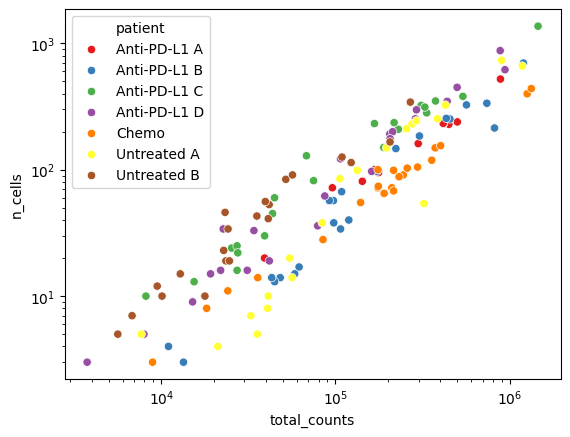

In [101]:
sns.scatterplot(data=pbulk_adata.obs, x='total_counts', y='n_cells', hue='patient', palette='Set1');
plt.xscale('log');plt.yscale('log');

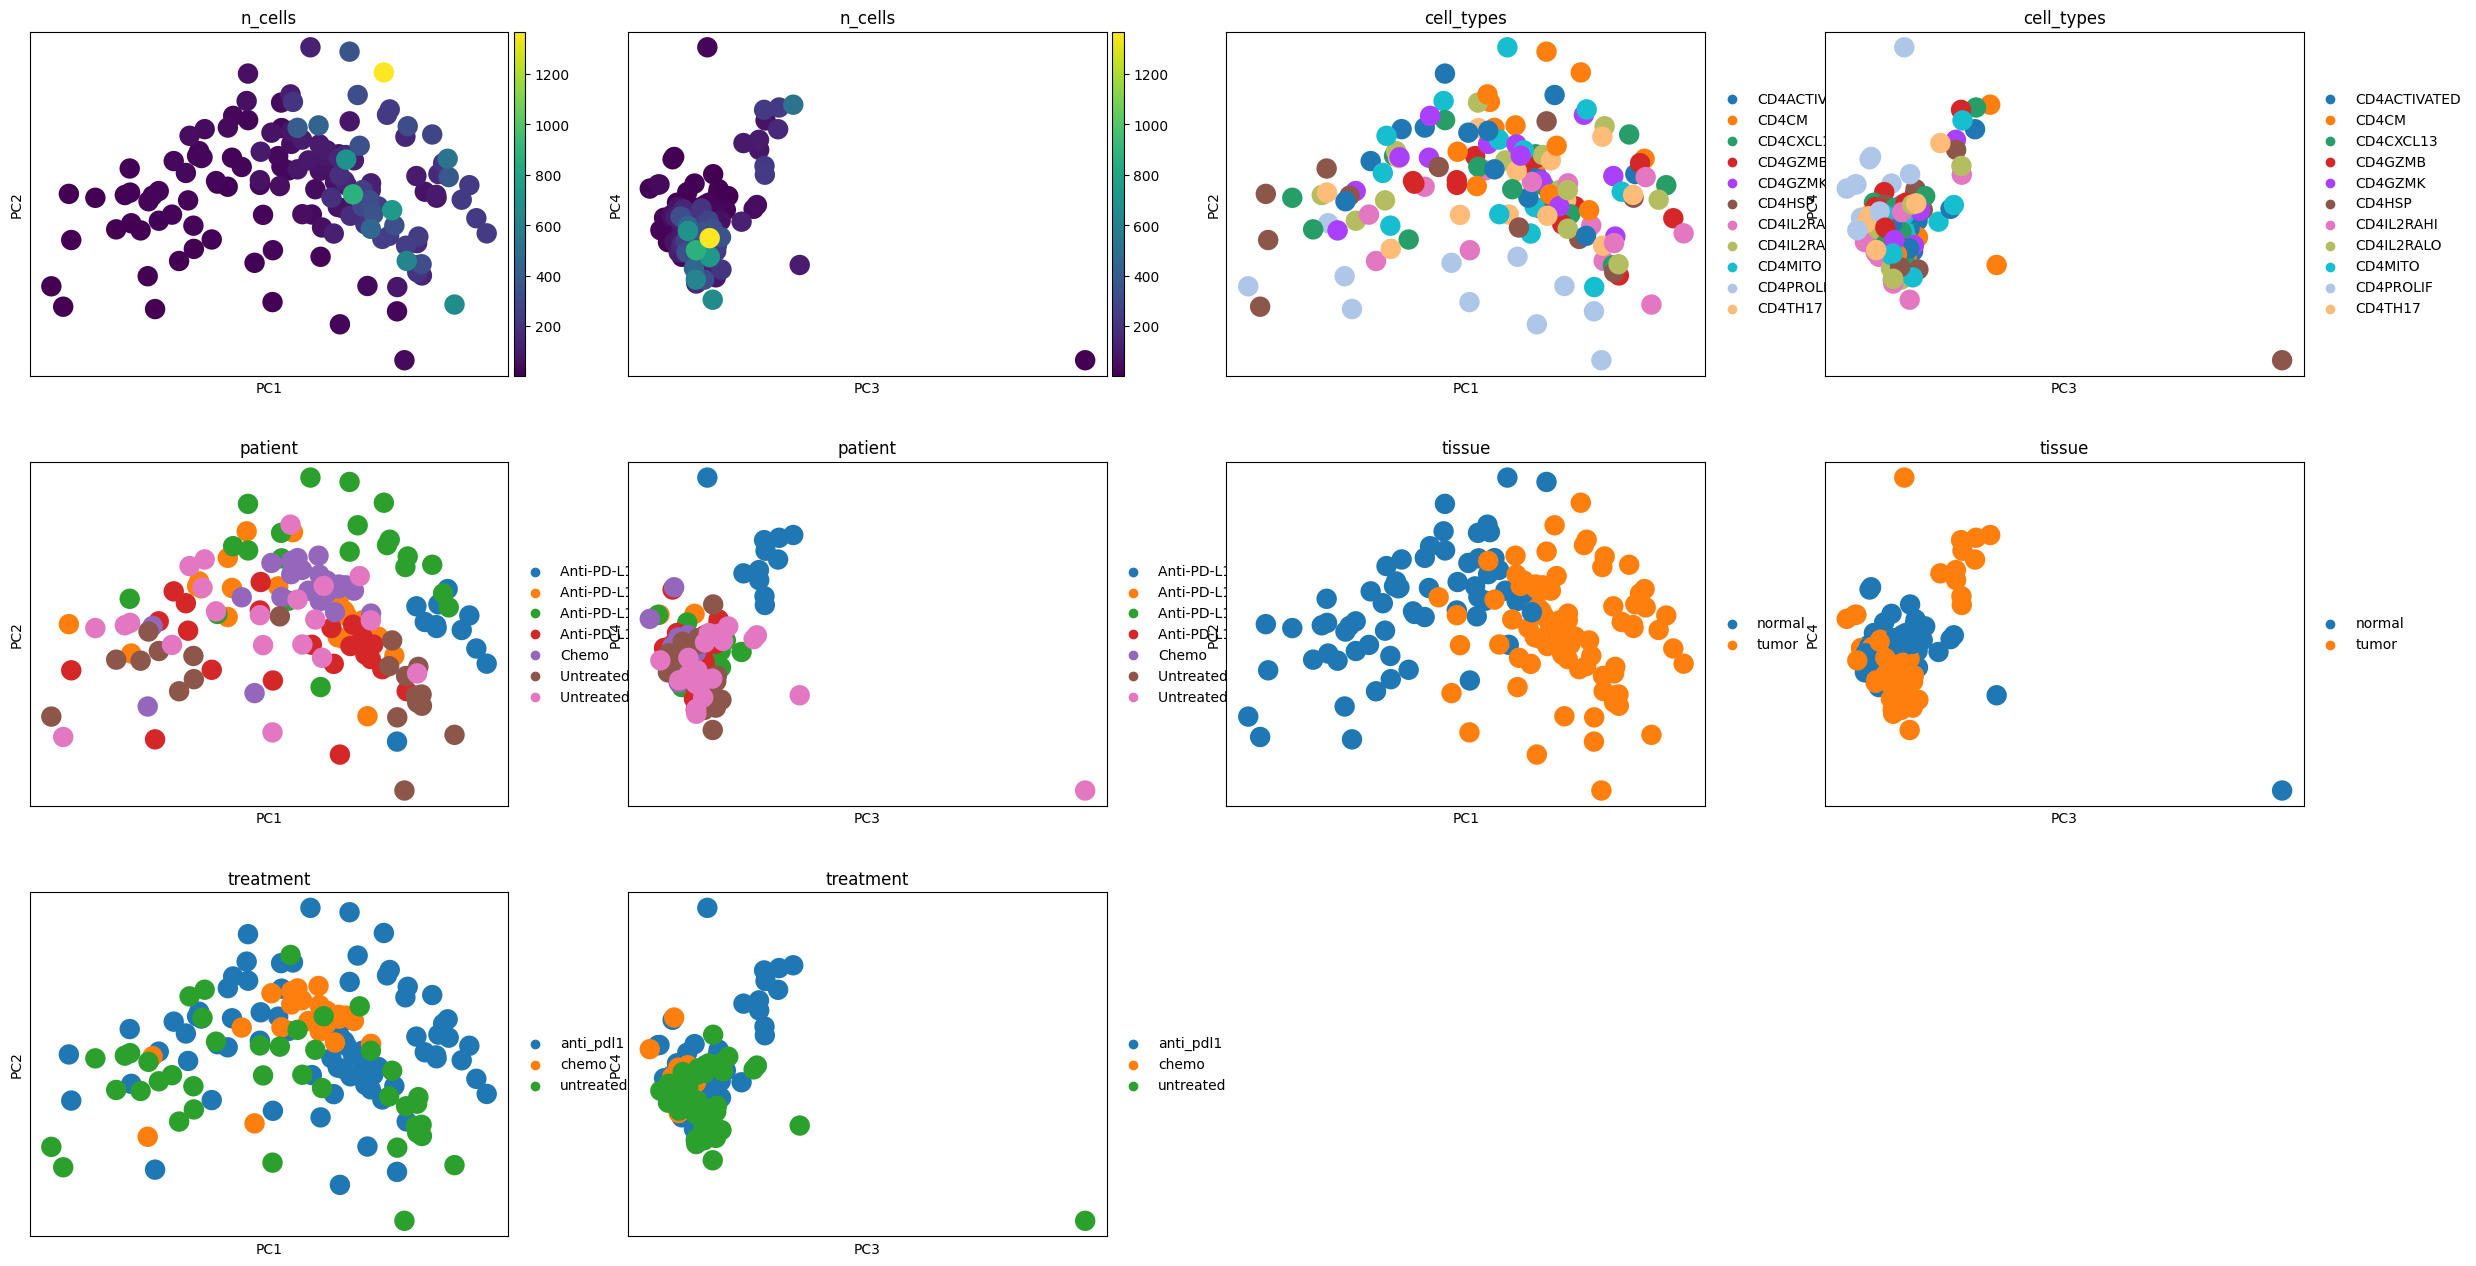

In [102]:
sc.pl.pca(pbulk_adata, color=['n_cells', 'cell_types', 'patient', 'tissue', 'treatment'], components=['1,2', '3,4'])

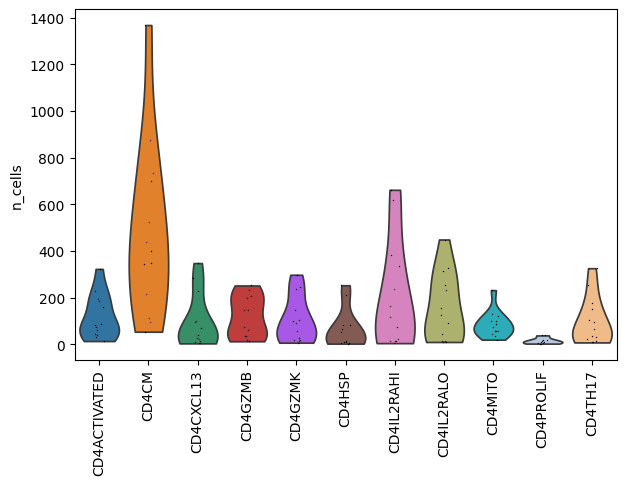

In [103]:
sc.pl.violin(pbulk_adata, 'n_cells',groupby='cell_types', rotation=90)

In [104]:
pbulk_adata[pbulk_adata.obs['tissue'] == 'tumor'].obs.sort_values('cell_types')

Sample_ID  \
Anti-PD-L1 A tumor CD4_tumor_anti_pdl1_Anti-PD-...  Anti-PD-L1 A tumor CD4   
Untreated A tumor CD4_tumor_untreated_Untreated...   Untreated A tumor CD4   
Untreated B tumor CD4_tumor_untreated_Untreated...   Untreated B tumor CD4   
Chemo tumor CD4_tumor_chemo_Chemo_CD4ACTIVATED             Chemo tumor CD4   
Anti-PD-L1 D tumor CD4_tumor_anti_pdl1_Anti-PD-...  Anti-PD-L1 D tumor CD4   
...                                                                    ...   
Anti-PD-L1 D tumor CD4_tumor_anti_pdl1_Anti-PD-...  Anti-PD-L1 D tumor CD4   
Chemo tumor CD4_tumor_chemo_Chemo_CD4TH17                  Chemo tumor CD4   
Anti-PD-L1 B tumor CD4_tumor_anti_pdl1_Anti-PD-...  Anti-PD-L1 B tumor CD4   
Anti-PD-L1 A tumor CD4_tumor_anti_pdl1_Anti-PD-...  Anti-PD-L1 A tumor CD4   
Untreated B tumor CD4_tumor_untreated_Untreated...   Untreated B tumor CD4   

                                                   tissue  treatment  \
Anti-PD-L1 A tumor CD4_tumor_anti_pdl1_Anti-PD-...  tumor  anti_pdl1   
Untreated A tumor CD4_tumor_untreated_Untreated...  tumor  untreated   
Untreated B tumor CD4_tumor_untreated_Untreated...  tumor  untreated   
Chemo tumor CD4_tumor_chemo_Chemo_CD4ACTIVATED      tumor      chemo   
Anti-PD-L1 D tumor CD4_tumor_anti_pdl1_Anti-PD-...  tumor  anti_pdl1   
...                                                   ...        ...   
Anti-PD-L1 D tumor CD4_tumor_anti_pdl1_Anti-PD-...  tumor  anti_pdl1   
Chemo tumor CD4_tumor_chemo_Chemo_CD4TH17           tumor      chemo   
Anti-PD-L1 B tumor CD4_tumor_anti_pdl1_Anti-PD-...  tumor  anti_pdl1   
Anti-PD-L1 A tumor CD4_tumor_anti_pdl1_Anti-PD-...  tumor  anti_pdl1   
Untreated B tumor CD4_tumor_untreated_Untreated...  tumor  untreated   

                                                         patient  \
Anti-PD-L1 A tumor CD4_tumor_anti_pdl1_Anti-PD-...  Anti-PD-L1 A   
Untreated A tumor CD4_tumor_untreated_Untreated...   Untreated A   
Untreated B tumor CD4_tumor_untreated_Untreated...   Untreated B   
Chemo tumor CD4_tumor_chemo_Chemo_CD4ACTIVATED             Chemo   
Anti-PD-L1 D tumor CD4_tumor_anti_pdl1_Anti-PD-...  Anti-PD-L1 D   
...                                                          ...   
Anti-PD-L1 D tumor CD4_tumor_anti_pdl1_Anti-PD-...  Anti-PD-L1 D   
Chemo tumor CD4_tumor_chemo_Chemo_CD4TH17                  Chemo   
Anti-PD-L1 B tumor CD4_tumor_anti_pdl1_Anti-PD-...  Anti-PD-L1 B   
Anti-PD-L1 A tumor CD4_tumor_anti_pdl1_Anti-PD-...  Anti-PD-L1 A   
Untreated B tumor CD4_tumor_untreated_Untreated...   Untreated B   

                                                      cell_types  n_cells  \
Anti-PD-L1 A tumor CD4_tumor_anti_pdl1_Anti-PD-...  CD4ACTIVATED      161   
Untreated A tumor CD4_tumor_untreated_Untreated...  CD4ACTIVATED      230   
Untreated B tumor CD4_tumor_untreated_Untreated...  CD4ACTIVATED       84   
Chemo tumor CD4_tumor_chemo_Chemo_CD4ACTIVATED      CD4ACTIVATED       88   
Anti-PD-L1 D tumor CD4_tumor_anti_pdl1_Anti-PD-...  CD4ACTIVATED      192   
...                                                          ...      ...   
Anti-PD-L1 D tumor CD4_tumor_anti_pdl1_Anti-PD-...       CD4TH17      176   
Chemo tumor CD4_tumor_chemo_Chemo_CD4TH17                CD4TH17      105   
Anti-PD-L1 B tumor CD4_tumor_anti_pdl1_Anti-PD-...       CD4TH17      326   
Anti-PD-L1 A tumor CD4_tumor_anti_pdl1_Anti-PD-...       CD4TH17       95   
Untreated B tumor CD4_tumor_untreated_Untreated...       CD4TH17       23   

                                                    total_counts  
Anti-PD-L1 A tumor CD4_tumor_anti_pdl1_Anti-PD-...      298591.0  
Untreated A tumor CD4_tumor_untreated_Untreated...      274966.0  
Untreated B tumor CD4_tumor_untreated_Untreated...       51854.0  
Chemo tumor CD4_tumor_chemo_Chemo_CD4ACTIVATED          231839.0  
Anti-PD-L1 D tumor CD4_tumor_anti_pdl1_Anti-PD-...      205084.0  
...                                                          ...  
Anti-PD-L1 D tumor CD4_tumor_anti_pdl1_Anti-PD-...  

In [105]:
sc.metrics.confusion_matrix('cell_types', 'Sample_ID',data=pbulk_adata[pbulk_adata.obs['tissue'] == 'tumor'].obs, normalize=False)

Sample_ID     Anti-PD-L1 A tumor CD4  Anti-PD-L1 B tumor CD4  \
cell_types                                                     
CD4ACTIVATED                       1                       1   
CD4CM                              1                       1   
CD4CXCL13                          1                       1   
CD4GZMB                            1                       1   
CD4GZMK                            1                       1   
CD4HSP                             1                       1   
CD4IL2RAHI                         1                       1   
CD4IL2RALO                         1                       1   
CD4MITO                            1                       1   
CD4PROLIF                          1                       1   
CD4TH17                            1                       1   

Sample_ID     Anti-PD-L1 C tumor CD4  Anti-PD-L1 D tumor CD4  Chemo tumor CD4  \
cell_types                                                                      
CD4ACTIVATED                       1                       1                1   
CD4CM                              1                       1                1   
CD4CXCL13                          1                       1                1   
CD4GZMB                            1                       1                1   
CD4GZMK                            1                       1                1   
CD4HSP                             1                       1                1   
CD4IL2RAHI                         1                       1                1   
CD4IL2RALO                         1                       1                1   
CD4MITO                            1                       1                1   
CD4PROLIF                          1                       1                1   
CD4TH17                            1                       1                1   

Sample_ID     Untreated A tumor CD4  Untreated B tumor CD4  
cell_types                                                  
CD4ACTIVATED                      1                      1  
CD4CM                             1                      1  
CD4CXCL13                         1                      1  
CD4GZMB                           1                      1  
CD4GZMK                           1                      1  
CD4HSP                            1                      1  
CD4IL2RAHI                        1                      1  
CD4IL2RALO                        1                      1  
CD4MITO                           1                      1  
CD4PROLIF                         1                      1  
CD4TH17                           1                      1

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/dds.py:245: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  self.X = adata.X.astype(int)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/dds.py:302: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = self.design
Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...
... done in 1.31 seconds.



Log2 fold change & Wald test p-value, contrast vector: [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_name                                                               
AL627309.1     0.035569       -2.373907  4.977633 -0.476915  0.633423   
AP006222.2     0.009822       -2.373907  4.977633 -0.476915  0.633423   
RP11-206L10.2  0.221619       -1.535429  1.412848 -1.086761  0.277142   
RP11-206L10.9  0.103803       -1.544613  2.178879 -0.708903  0.478385   
FAM87B         0.015251       -2.373902  4.977633 -0.476914  0.633423   
...                 ...             ...       ...       ...       ...   
AC011841.1     0.130392       -2.373901  3.963559 -0.598932  0.549218   
AL354822.1     0.582648       -1.540327  1.621870 -0.949723  0.342253   
KIR2DL2        0.079893       -1.579548  4.898883 -0.322430  0.747127   
PNRC2-1        3.765030        1.758844  0.616651  2.852251  0.004341   
SRSF10-1       2.573735        1.4

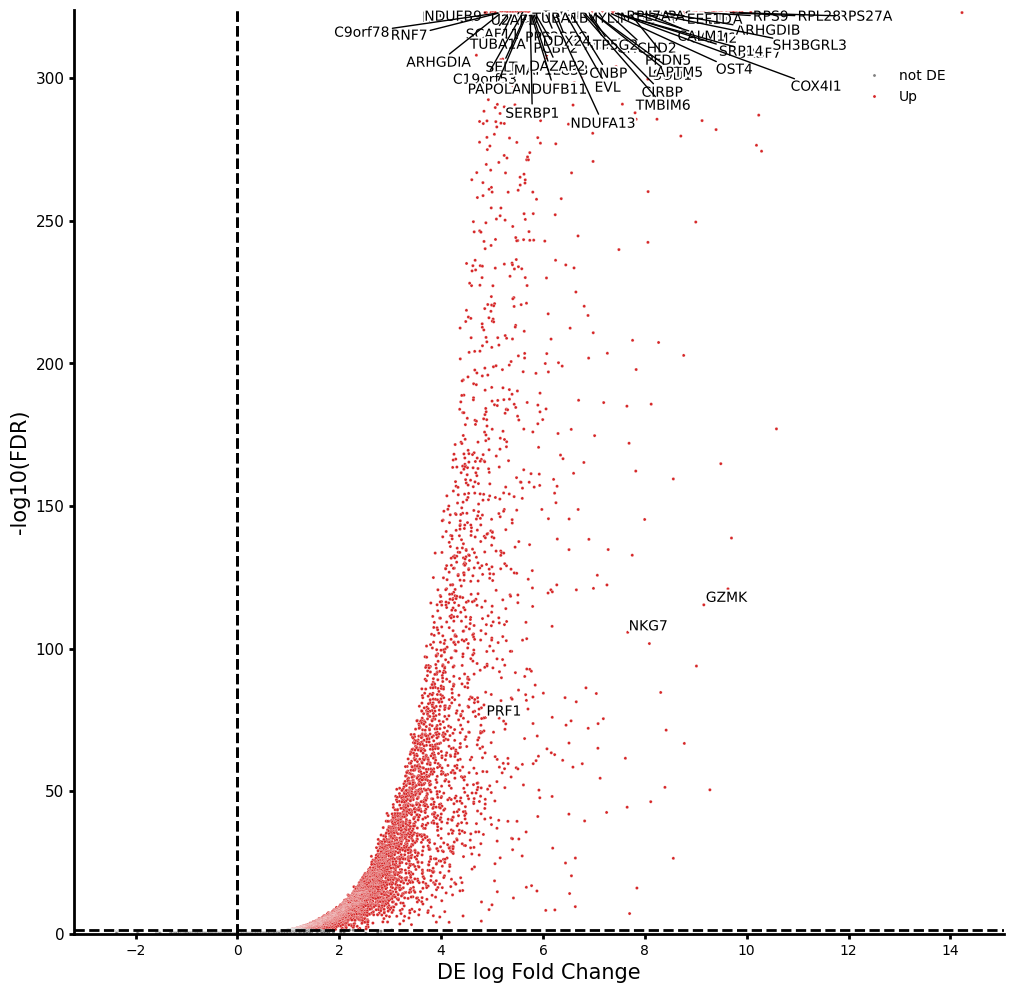

In [106]:
# model = pertpy.tl.PyDESeq2(pbulk_adata, design='~ tissue + patient_id + cell_types', layer='sum')
model = pertpy.tl.PyDESeq2(pbulk_adata[pbulk_adata.obs['tissue'] == 'tumor'], design='~ cell_types', layer='sum')
model.fit(quiet=True)

# Run differential expression for each polarization condition vs Th0
cytotoxic_contrast = model.cond(cell_types = 'CD4GZMK') 
res_df = model.test_contrasts(cytotoxic_contrast)
annot_gs = res_df[0:50].variable.tolist() + ['GZMK', 'PRF1', "NKG7"]

fig = model.plot_volcano(
    res_df, 
    log2fc_thresh=0, 
    return_fig=True, 
    to_label = annot_gs,
    figsize=(12, 12),
    s=5,
    legend_pos = (0.95,0.95),
    x_label = 'DE log Fold Change',
    y_label = '-log10(FDR)'
    )

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarni

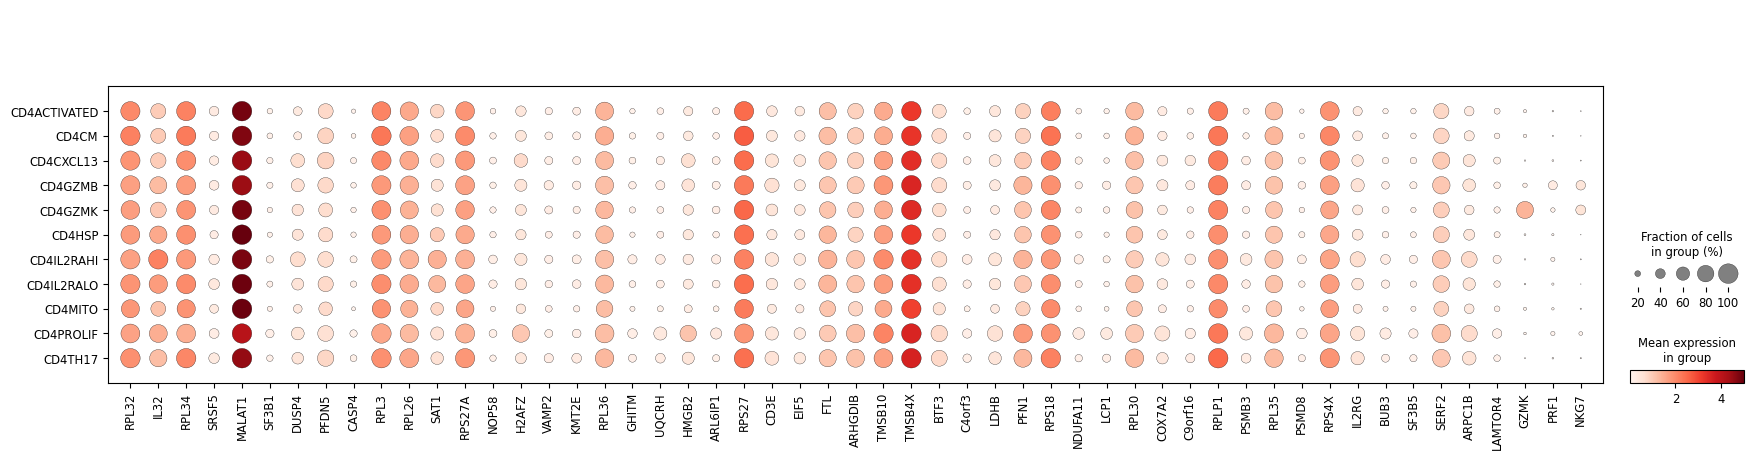

In [15]:
sc.pl.dotplot(adata[adata.obs['tissue'] == 'tumor'], annot_gs, groupby='cell_types')

Option 2 - cytotoxic vs CM

Running Wald tests...
... done in 0.72 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0. -1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_name                                                               
RP11-206L10.2  0.223553        0.935710  1.868244  0.500850  0.616477   
RP11-206L10.9  0.105491        1.624695  3.070217  0.529179  0.596681   
LINC00115      0.587820        0.625484  1.034812  0.604442  0.545550   
FAM41C         0.016679        2.081780  7.033953  0.295962  0.767259   
KLHL17         0.179920        0.260703  2.959462  0.088091  0.929804   
...                 ...             ...       ...       ...       ...   
AL592183.1     8.706200       -0.490138  0.412877 -1.187129  0.235177   
AC011841.1     0.129330        0.752109  6.138877  0.122516  0.902491   
AL354822.1     0.564186        1.532764  2.259214  0.678450  0.497486   
KIR2DL2        0.074478        2.861070  6.979579  0.409920  0.681865   
PNRC2-1        3.744062

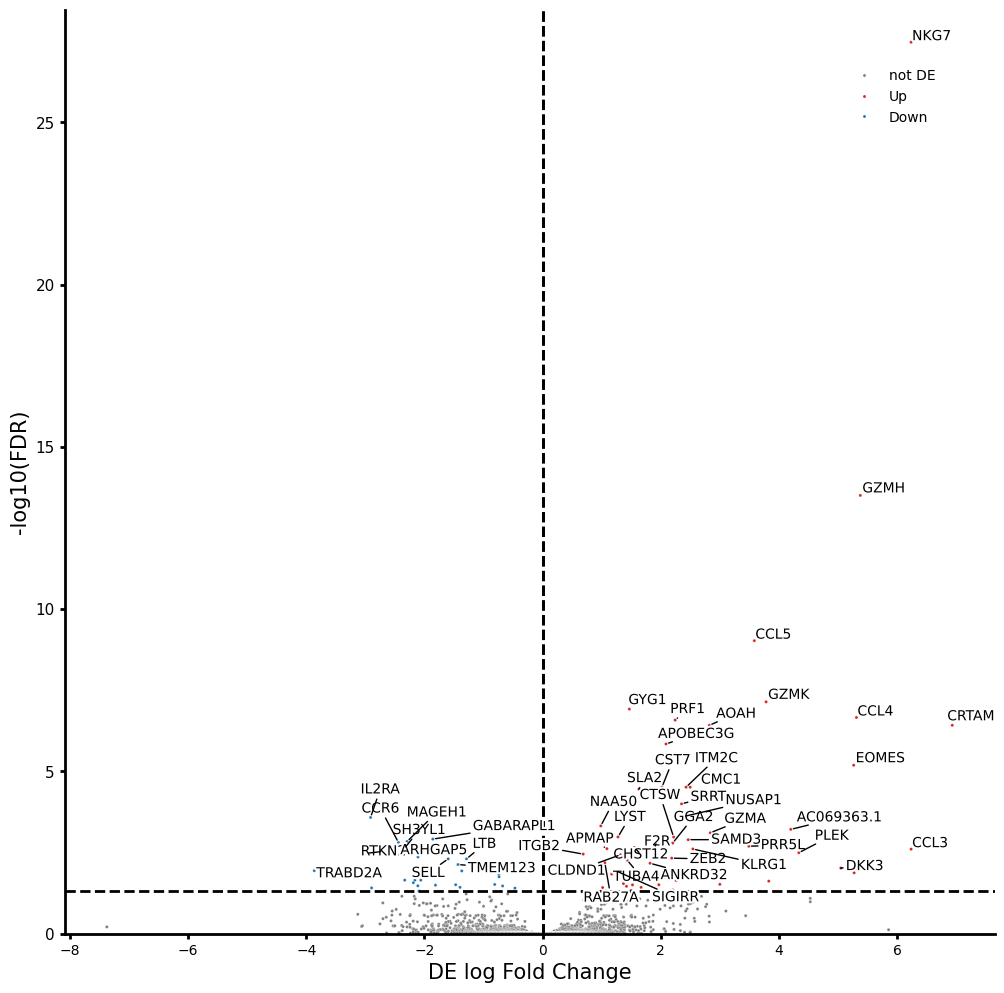

In [16]:
cytotoxic_contrast = model.cond(cell_types = 'CD4GZMK') - model.cond(cell_types = 'CD4CM') 
res_df = model.test_contrasts(cytotoxic_contrast)
annot_gs = res_df[0:50].variable.tolist() + ['GZMK', 'PRF1', "NKG7"]

fig = model.plot_volcano(
    res_df, 
    log2fc_thresh=0, 
    return_fig=True, 
    to_label = annot_gs,
    figsize=(12, 12),
    s=5,
    legend_pos = (0.95,0.95),
    x_label = 'DE log Fold Change',
    y_label = '-log10(FDR)'
    )

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarni

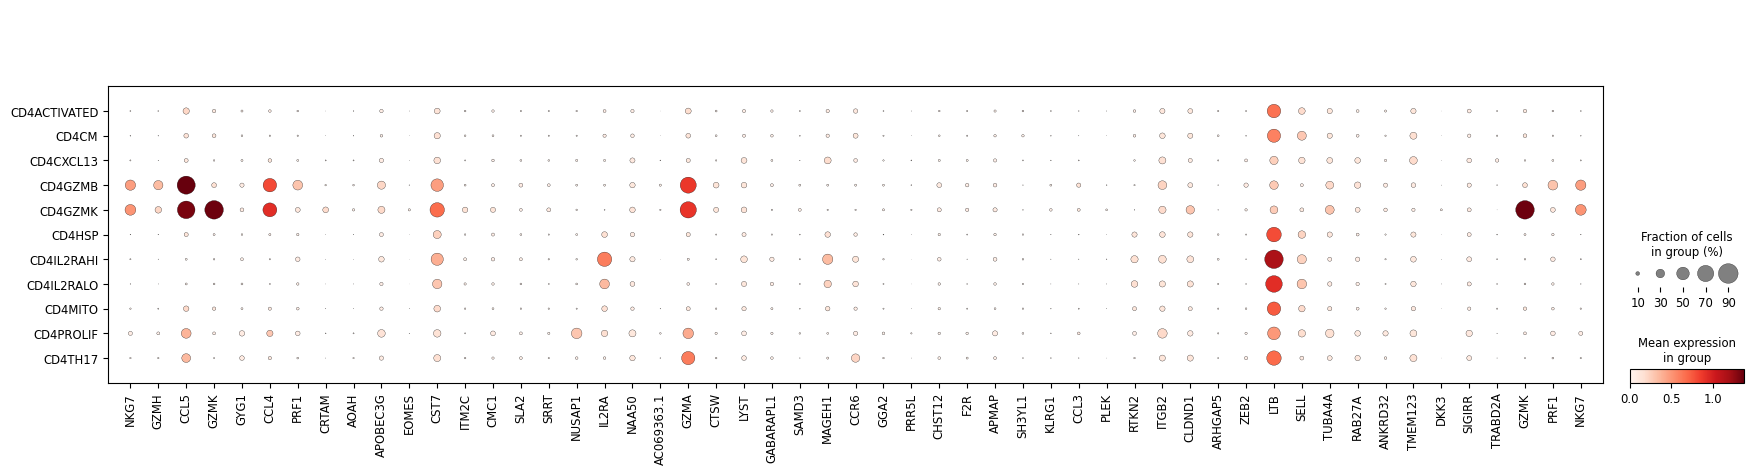

In [17]:
sc.pl.dotplot(adata[adata.obs['tissue'] == 'tumor'], annot_gs, groupby='cell_types')

Option 3 - one vs all but aggregating cytotoxic vs not cytotoxic

In [107]:
adata.obs['cytotoxic'] = np.where(adata.obs['cell_types'].isin(['CD4GZMK', 'CD4GZMB']), 'cytotoxic', 'other')
pbulk_adata = sc.get.aggregate(adata, by=['Sample_ID', 'tissue','treatment', 'patient','cytotoxic'], func=['sum'], layer='counts')
n_cells = adata.obs.groupby(['Sample_ID', 'tissue','treatment', 'patient','cytotoxic']).size().reset_index().rename({0:'n_cells'}, axis=1)

obs_df = pd.merge(pbulk_adata.obs, n_cells)
obs_df.index = pbulk_adata.obs_names.copy()
pbulk_adata.obs = obs_df.copy()
pbulk_adata = pbulk_adata[pbulk_adata.obs['n_cells'] >= 3].copy()

# HVGs
pbulk_adata.X = pbulk_adata.layers['sum'].copy()
sc.pp.normalize_total(pbulk_adata)
sc.pp.log1p(pbulk_adata)
sc.pp.highly_variable_genes(pbulk_adata, n_top_genes=20000)
pbulk_adata = pbulk_adata[:, pbulk_adata.var['highly_variable']].copy()
sc.pp.scale(pbulk_adata)
sc.pp.pca(pbulk_adata)
pbulk_adata.X = pbulk_adata.layers['sum'].copy()

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:415: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/dds.py:245: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  self.X = adata.X.astype(int)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/dds.py:302: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = self.design
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Running Wald tests...
... done in 1.14 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0. -1.]
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_name                                                                
AL627309.1      0.227797        0.265080  1.534576  0.172738  0.862857   
AP006222.2      0.145526        3.071902  3.365989  0.912630  0.361437   
RP11-206L10.2   1.411872        0.605213  0.877136  0.689987  0.490202   
RP11-206L10.9   0.752086        0.597765  1.007350  0.593404  0.552911   
FAM87B          0.137970        2.659713  2.116793  1.256482  0.208941   
...                  ...             ...       ...       ...       ...   
AC011841.1      0.220668       -0.126958  1.433001 -0.088596  0.929403   
AL354822.1      2.434437       -0.605379  1.551379 -0.390220  0.696374   
KIR2DL2         1.039896        4.188238  3.017477  1.387994  0.165139   
PNRC2-1        19.211866       -0.178067  0.902905 -0.197215  0.843659   
SRSF10-1       14.668947        0.222309  0.506

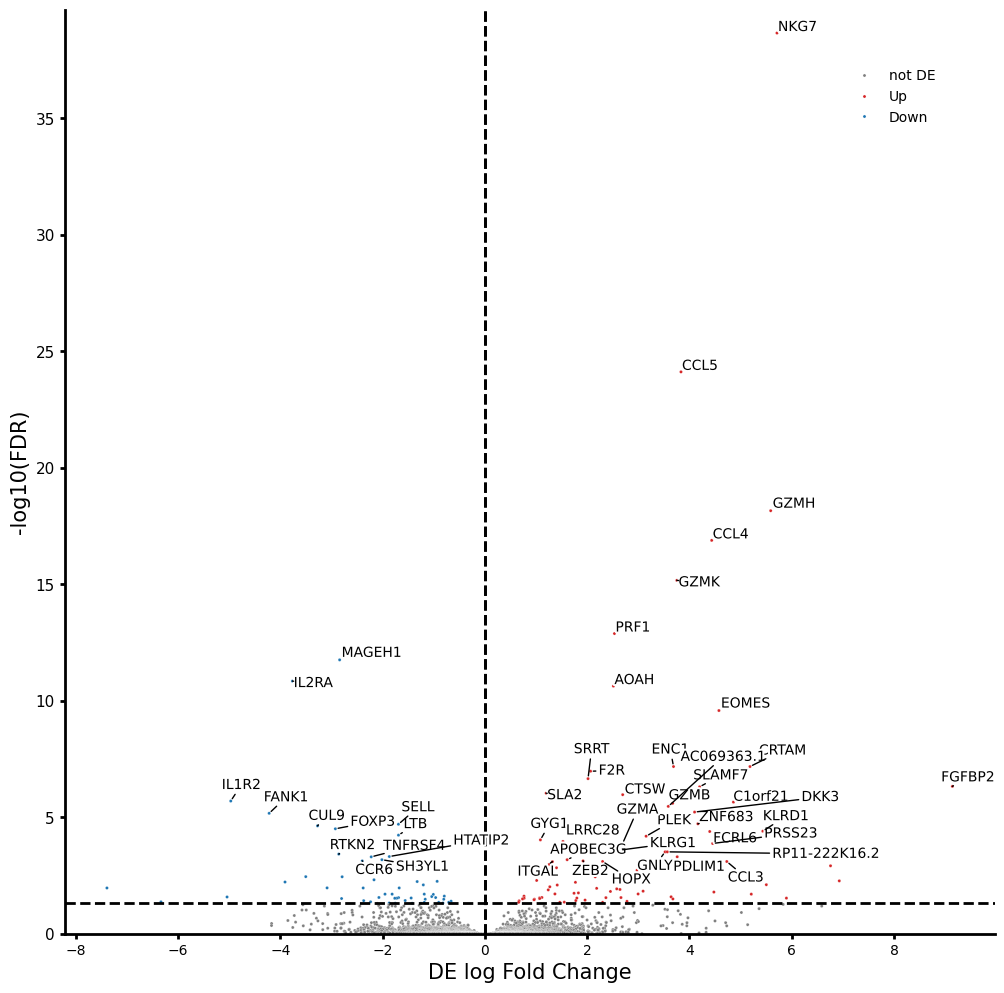

In [108]:
model = pertpy.tl.PyDESeq2(pbulk_adata[pbulk_adata.obs['tissue'] == 'tumor'], design='~ cytotoxic', layer='sum')
model.fit(quiet=True)

# Run differential expression for each polarization condition vs Th0
cytotoxic_contrast = model.cond(cytotoxic = 'cytotoxic') - model.cond(cytotoxic = 'other')
res_df = model.test_contrasts(cytotoxic_contrast)
annot_gs = res_df[0:50].variable.tolist() + ['GZMK', 'PRF1', "NKG7"]

fig = model.plot_volcano(
    res_df, 
    log2fc_thresh=0, 
    return_fig=True, 
    to_label = annot_gs,
    figsize=(12, 12),
    s=5,
    legend_pos = (0.95,0.95),
    x_label = 'DE log Fold Change',
    y_label = '-log10(FDR)'
    )

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarni

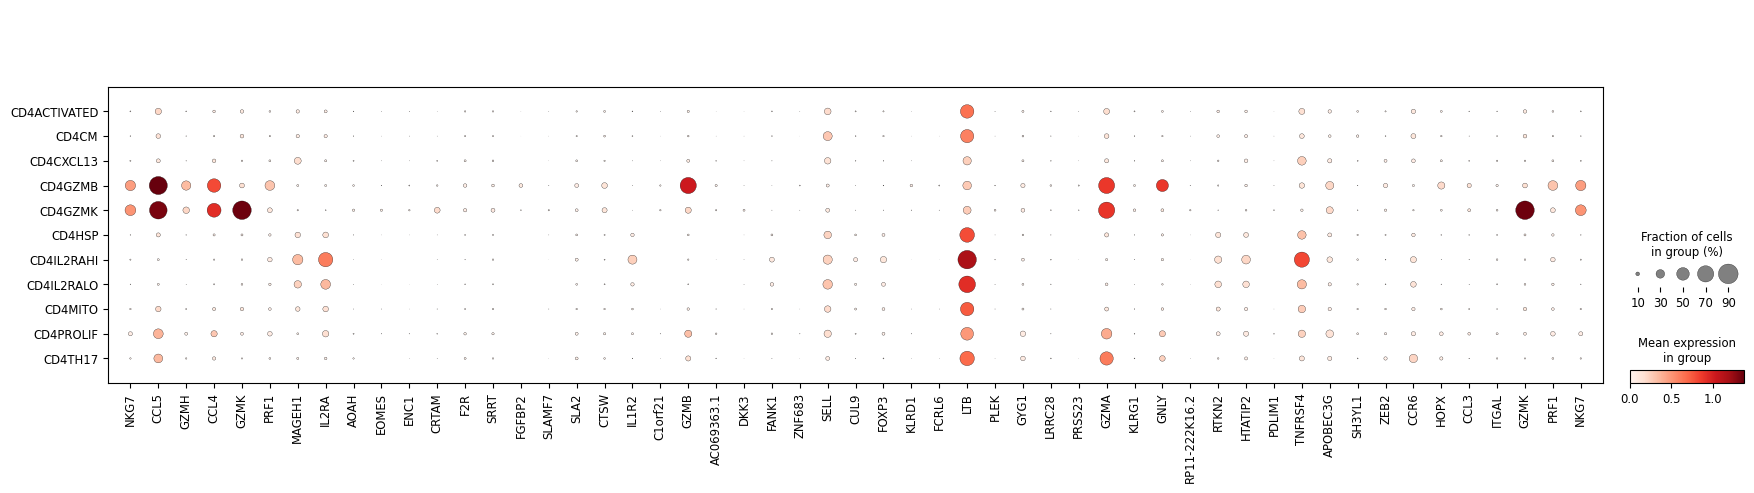

In [109]:
sc.pl.dotplot(adata[adata.obs['tissue'] == 'tumor'], annot_gs, groupby='cell_types')

 ### Save cytotoxicity signautre

/tmp/ipykernel_2307188/2840820864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cytotoxic_signature['zscore'] = cytotoxic_signature['log_fc']/cytotoxic_signature['lfcSE']


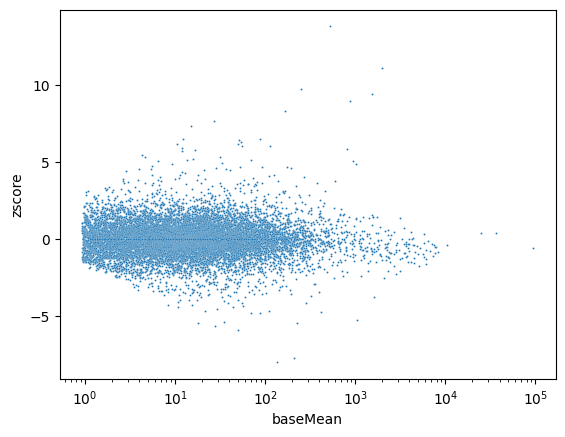

In [110]:
res_df['contrast'] = 'cytotoxic_vs_rest'
cytotoxic_signature = res_df.dropna()
cytotoxic_signature['zscore'] = cytotoxic_signature['log_fc']/cytotoxic_signature['lfcSE']
sns.scatterplot(data=cytotoxic_signature, x='baseMean', y='zscore', s=2);
plt.xscale('log')

cytotoxic_signature.to_csv('cytotoxicCD4_signature.csv')

In [3]:
cytotoxic_signature = pd.read_csv('cytotoxicCD4_signature.csv', index_col=0)

## Load perturb-seq signatures

In [4]:
# Import utility functions from DE_analysis_utils.py
import sys
import os
sys.path.append(os.path.abspath('../3_DE_analysis'))
from DE_analysis_utils import get_DE_results_long


In [5]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4iR1_Psomagen/'
experiment_name = 'CD4iR1_Psomagen'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')

adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50
for cond in adata_de.obs.culture_condition.unique():
    affected_gs_cond = np.sum(adata_de[adata_de.obs['culture_condition'] == cond].layers['adj_p_value'] < 0.1, axis=0)
    adata_de.var[f'n_signif_effects_{cond}'] = affected_gs_cond
    # affected_gs_cond = np.sum(adata_de[adata_de.obs['culture_condition'] == cond].layers['MASH_lfsr'] < 0.05, axis=0)
    # adata_de.var[f'n_mash_signif_effects_{cond}'] = affected_gs_cond

adata_de.var_names = adata_de.var['gene_name'].values
adata_de.var_names

Index(['TSPAN6', 'DPM1', 'C1orf112', 'FGR', 'CFH', 'FUCA2', 'GCLC', 'NFYA',
       'STPG1', 'NIPAL3',
       ...
       'SMIM33', 'MSANTD7', 'SCO2', 'C2orf81', 'TBCE', 'ARHGAP11B', 'F8A1',
       'HOMEZ', 'ENSG00000290797', 'SOD2'],
      dtype='object', length=10079)

In [6]:
# Load summary stats
DE_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)
keep_targets = DE_stats[ (DE_stats.n_total_de_genes > 1)].target_name.tolist()
print(len(keep_targets))

7402


In [7]:
k562_adata_de = sc.read_h5ad('/mnt/oak/users/emma/data/GWT/K562_DE_analysis/K562.merged_DE_results.h5ad')

k562_adata_de.layers['zscore'] = k562_adata_de.layers['log_fc'] / k562_adata_de.layers['lfcSE']
k562_adata_de.layers['zscore'][np.where(k562_adata_de.layers['zscore'] > 50)] = 50
k562_adata_de

AnnData object with n_obs × n_vars = 3081 × 6294
    obs: 'culture_condition', 'target_contrast', 'chunk', 'target_contrast_gene_name', 'n_cells_target'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

## Fit signature

In [8]:
from perturb2tissue_eval import *


def unpack_state_results(model_results, state):
    return {
        'p2t_model': model_results[state]['p2t_model'],
        'p2t_model_k562': model_results[state]['p2t_model_k562'],
        'X_perturbs': model_results[state]['X_perturbs'],
        'y_target': model_results[state]['y_target'],
        'common_gs': model_results[state]['common_gs']
    }

### Comparison with K562 data
Subsetting to common perturbations

In [9]:
target_state = 'cytotoxic_vs_rest'
perturb_layer = 'zscore'
ctrl_de = k562_adata_de
n_pcs = 30
n_splits = 5
n_repeats = 1

# Get target state values
y_target = cytotoxic_signature.pivot_table(index='variable', columns='contrast', values=perturb_layer)[target_state]

# Find common genes between all DE results
common_gs = np.intersect1d(y_target.index, adata_de.var_names)
print(f"Common genes between target and adata_de: {len(common_gs)}")

if ctrl_de is not None:
    # Map gene IDs to gene names for K562 comparison
    common_gs_ids_df = adata_de[:, common_gs].var[['gene_ids', 'gene_name']]
    common_gs_ids = common_gs_ids_df[common_gs_ids_df.gene_name.isin(ctrl_de.var_names)].gene_name
    print(f"Common gene IDs with K562: {len(common_gs_ids)}")
    
    k562_de_test = ctrl_de[:, ctrl_de.var_names.isin(common_gs_ids)].copy()
    common_gs = np.intersect1d(common_gs, k562_de_test.var_names)

Common genes between target and adata_de: 7668
Common gene IDs with K562: 5530


In [10]:
y_target = y_target.loc[common_gs]

# Get responses in stim cells
print(f"Getting perturbation responses for condition: {cond}")
X_perturbs = sc.get.obs_df(adata_de[adata_de.obs.culture_condition == cond], 
                            ['target_contrast_gene_name'] + list(common_gs), 
                            layer=perturb_layer)
X_perturbs = X_perturbs.set_index('target_contrast_gene_name').T
print(f"Perturbation matrix shape: {X_perturbs.shape}")

if ctrl_de is not None:
    X_perturbs_ctrl = sc.get.obs_df(k562_de_test, 
                            ['target_contrast_gene_name'] + list(common_gs), 
                            layer=perturb_layer)
    X_perturbs_ctrl = X_perturbs_ctrl.set_index('target_contrast_gene_name').T
    # Find common perturbations between CD4 and K562
    common_perturbs = np.intersect1d(X_perturbs_ctrl.columns, X_perturbs.columns)
    print(f"Common perturbations between CD4 and K562: {len(common_perturbs)}")
    X_perturbs = X_perturbs[common_perturbs]
    X_perturbs_ctrl = X_perturbs_ctrl[common_perturbs]
    X_perturbs_ctrl_masked = X_perturbs_ctrl.copy()
    mask = pd.DataFrame(False, index=X_perturbs_ctrl_masked.index, columns=X_perturbs_ctrl_masked.columns)
    for idx in X_perturbs_ctrl_masked.index:
        if idx in X_perturbs_ctrl_masked.columns:
            mask.loc[idx, idx] = True
    X_perturbs_ctrl_masked = X_perturbs_ctrl_masked.mask(mask)
    # Impute masked values with column means
    X_perturbs_ctrl_masked = X_perturbs_ctrl_masked.fillna(X_perturbs_ctrl_masked.mean())

# Mask effects in cis
X_perturbs_masked = X_perturbs.copy()
mask = pd.DataFrame(False, index=X_perturbs_masked.index, columns=X_perturbs_masked.columns)
for idx in X_perturbs_masked.index:
    if idx in X_perturbs_masked.columns:
        mask.loc[idx, idx] = True
X_perturbs_masked = X_perturbs_masked.mask(mask)
# Impute masked values with column means
X_perturbs_masked = X_perturbs_masked.fillna(X_perturbs_masked.mean())

# Train model on CD4 cells
print(f"Training CD4 model with {n_pcs} PCs, {n_splits} splits, {n_repeats} repeats")
p2t_model = Perturb2TissueModel(pca_transform=True, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=False)
p2t_model.fit(X_perturbs_masked, y_target, model_id=f'{cond}')
print(f"CD4 model training complete.")

# Train model on K562 cells if provided
p2t_model_k562 = None
if ctrl_de is not None:
    print(f"Training K562 model with {n_pcs} PCs, {n_splits} splits, {n_repeats} repeats")
    p2t_model_k562 = Perturb2TissueModel(pca_transform=True, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=False)
    p2t_model_k562.fit(X_perturbs_ctrl_masked, y_target, model_id=f'K562')
    print(f"K562 model training complete.")

print(f"Model training for {target_state} completed successfully")



Getting perturbation responses for condition: Rest
Perturbation matrix shape: (5530, 8481)
Common perturbations between CD4 and K562: 2950
Training CD4 model with 30 PCs, 5 splits, 1 repeats
CD4 model training complete.
Training K562 model with 30 PCs, 5 splits, 1 repeats
K562 model training complete.
Model training for cytotoxic_vs_rest completed successfully


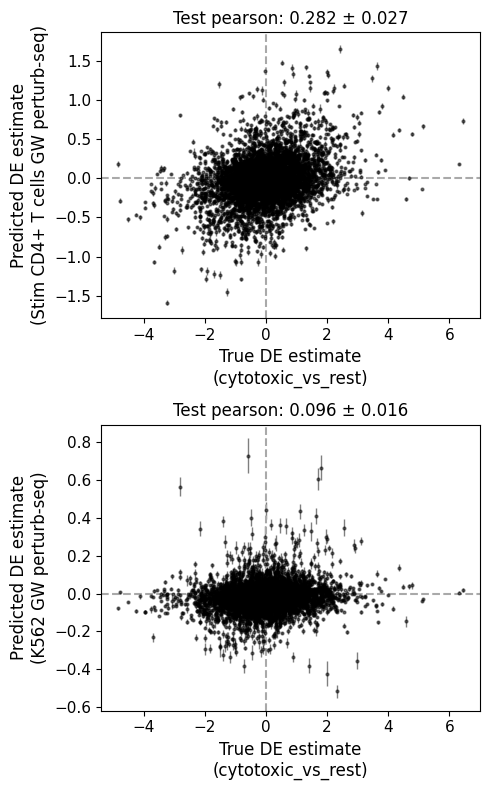

In [115]:
st = target_state
common_gs_ids_df = adata_de[:, common_gs].var[['gene_ids', 'gene_name']]
common_gs_ids = common_gs_ids_df.gene_ids

# Create a figure with subplots for all conditions
fig, axes = plt.subplots(2, 1, figsize=(5, 8))

# Plot predictions for the main model in the top subplot
p2t_model.plot_prediction(X_perturbs, y_target, plot_metric='pearson', ax=axes[0], return_ax=True)
axes[0].set_ylabel('Predicted DE estimate\n(Stim CD4+ T cells GW perturb-seq)', fontsize=12)
axes[0].set_xlabel(f'True DE estimate\n({st})', fontsize=12)
axes[0].axhline(y=0, color='darkgrey', linestyle='--')
axes[0].axvline(x=0, color='darkgrey', linestyle='--')

# Plot predictions for the K562 model in the bottom subplot
p2t_model_k562.plot_prediction(X_perturbs_ctrl, y_target, plot_metric='pearson', ax=axes[1], return_ax=True)
axes[1].set_ylabel('Predicted DE estimate\n(K562 GW perturb-seq)', fontsize=12)
axes[1].set_xlabel(f'True DE estimate\n({st})', fontsize=12)
axes[1].axhline(y=0, color='darkgrey', linestyle='--')
axes[1].axvline(x=0, color='darkgrey', linestyle='--')

plt.tight_layout()
plt.show()


### Train model on all KDs measured in T cells

In [11]:
target_state = 'cytotoxic_vs_rest'
perturb_layer = 'zscore'
ctrl_de = k562_adata_de
n_pcs = 60
n_splits = 5
n_repeats = 1
cond = 'Rest'

# Get target state values
y_target = cytotoxic_signature.pivot_table(index='variable', columns='contrast', values=perturb_layer)[target_state]

# Find common genes between all DE results
common_gs = np.intersect1d(y_target.index, adata_de.var_names)

y_target = y_target.loc[common_gs]

# Get responses in stim cells
print(f"Getting perturbation responses for condition: {cond}")
X_perturbs = sc.get.obs_df(adata_de[adata_de.obs.culture_condition == cond], 
                            ['target_contrast_gene_name'] + list(common_gs), 
                            layer=perturb_layer)
X_perturbs = X_perturbs.set_index('target_contrast_gene_name').T
print(f"Perturbation matrix shape: {X_perturbs.shape}")

# Mask effects in cis
X_perturbs_masked = X_perturbs.copy()
mask = pd.DataFrame(False, index=X_perturbs_masked.index, columns=X_perturbs_masked.columns)
for idx in X_perturbs_masked.index:
    if idx in X_perturbs_masked.columns:
        mask.loc[idx, idx] = True
X_perturbs_masked = X_perturbs_masked.mask(mask)
# Impute masked values with column means
X_perturbs_masked = X_perturbs_masked.fillna(X_perturbs_masked.mean())

# Train model on CD4 cells
print(f"Training CD4 model with {n_pcs} PCs, {n_splits} splits, {n_repeats} repeats")
p2t_model = Perturb2TissueModel(pca_transform=True, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=False)
p2t_model.fit(X_perturbs_masked, y_target, model_id=f'{cond}')

Getting perturbation responses for condition: Rest
Perturbation matrix shape: (7668, 8481)
Training CD4 model with 60 PCs, 5 splits, 1 repeats


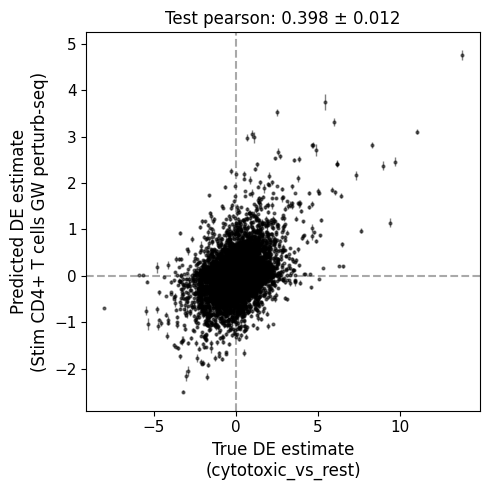

In [12]:
st = target_state
common_gs_ids_df = adata_de[:, common_gs].var[['gene_ids', 'gene_name']]
common_gs_ids = common_gs_ids_df.gene_ids

# Create a figure with subplots for all conditions
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

# Process each state
# Plot predictions for the main model in the top subplot
p2t_model.plot_prediction(X_perturbs, y_target, plot_metric='pearson', ax=axes, return_ax=True)
axes.set_ylabel('Predicted DE estimate\n(Stim CD4+ T cells GW perturb-seq)', fontsize=12)
axes.set_xlabel(f'True DE estimate\n({st})', fontsize=12)
axes.axhline(y=0, color='darkgrey', linestyle='--')
axes.axvline(x=0, color='darkgrey', linestyle='--')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'cytotoxic_vs_rest')

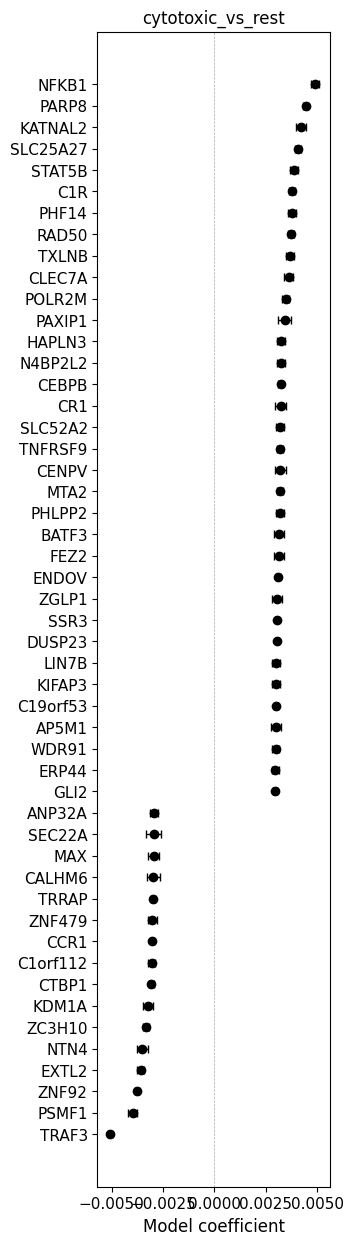

In [13]:
# Create a figure with subplots for all states in one row
fig, ax = plt.subplots(1, 1, figsize=(3, 15))
p2t_model.plot_coefs(top_n=50, ax=ax, return_ax=True, show_labels=True)
ax.set_title(st)


Text(0.5, 1.0, 'cytotoxic_vs_rest')

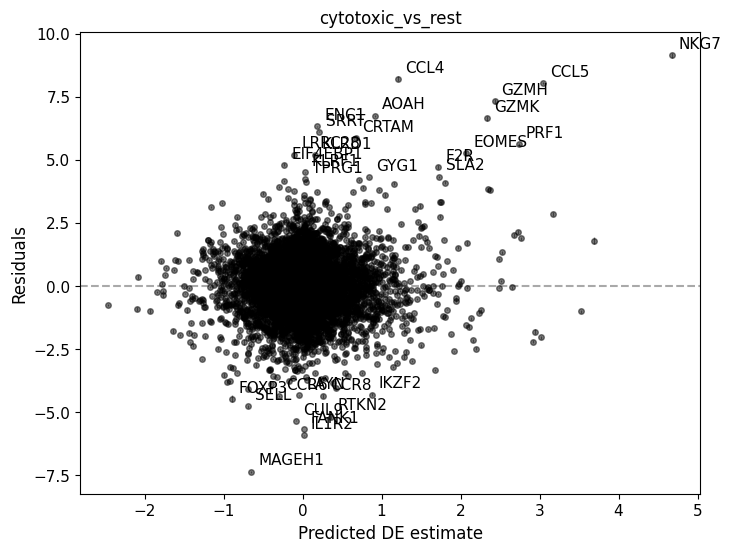

In [128]:
pl = p2t_model.plot_residuals(X_perturbs, y_target, annotate_top_n=30)
plt.title(st)

In [16]:
all_coefs = pd.DataFrame()
pt_coefs = p2t_model.get_coefs()
pt_coefs['state'] = st
all_coefs = pd.concat([all_coefs, pt_coefs])

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

top_quant = 0.005
alpha = 0.05

# Get DE geens with activation (Arce et al)
act_signature_df = pd.read_csv('Arce2024_20230130_DESeq2_output_AAVS1_Teff_Stimulation_vs_Resting.csv')
act_signature_df['zscore'] = act_signature_df['log2FoldChange']/act_signature_df['lfcSE']
activation_genes = act_signature_df[(act_signature_df['zscore'].abs() > 5) & (act_signature_df['padj'] < 0.01)]['gene_name']

# Get top DE genes for input signature
state_results_df = cytotoxic_signature[cytotoxic_signature['contrast'] == st]
pl_df = pd.merge(cytotoxic_signature, act_signature_df.rename({'zscore':'zscore_act', 'gene_name':'variable'}, axis=1)[['zscore_act', 'variable']])
state_results_df['activation_genes'] = state_results_df['variable'].isin(activation_genes)
signature_effect_size = state_results_df[state_results_df['adj_p_value'] < alpha].sort_values('zscore')
signature_gs = signature_effect_size.variable.tolist()

# Get top and bottom 10% of coefficient values
n = len(all_coefs['coef_mean'])
st_coefs = all_coefs[all_coefs['state'] == st].copy()
top_10_percent = st_coefs['coef_mean'].nlargest(int(n * top_quant))
bottom_10_percent = st_coefs['coef_mean'].nsmallest(int(n * top_quant))
predicted_effect_size = pd.concat([top_10_percent, bottom_10_percent]).sort_values(ascending=False)
predicted_regulators = predicted_effect_size.index.tolist()

# Get DE results and pivot to wide format
long_de_results = get_DE_results_long(adata_de, targets=predicted_regulators, genes=signature_gs, gene_id_col='gene_name')
long_de_results = long_de_results[long_de_results['culture_condition'] == 'Stim8hr'].copy()
wide_de_results = long_de_results.pivot(index='gene', columns='target_contrast_gene_name', values='zscore')
wide_de_results_signif = long_de_results.pivot(index='gene', columns='target_contrast_gene_name', values='adj_p_value')

# Create a mask where column names match index names and set those values to 0
mask = pd.DataFrame(False, index=wide_de_results.index, columns=wide_de_results.columns)
for idx in wide_de_results.index:
    if idx in wide_de_results.columns:
        mask.loc[idx, idx] = True
wide_de_results = wide_de_results.mask(mask, 0)
wide_de_results = wide_de_results.T

# Define axis labels
wide_de_results.index.name = 'Regulators (CRISPRi targets)'
wide_de_results.columns.name = f'{st} signature genes (5% FDR)'

<Figure size 3000x1500 with 0 Axes>

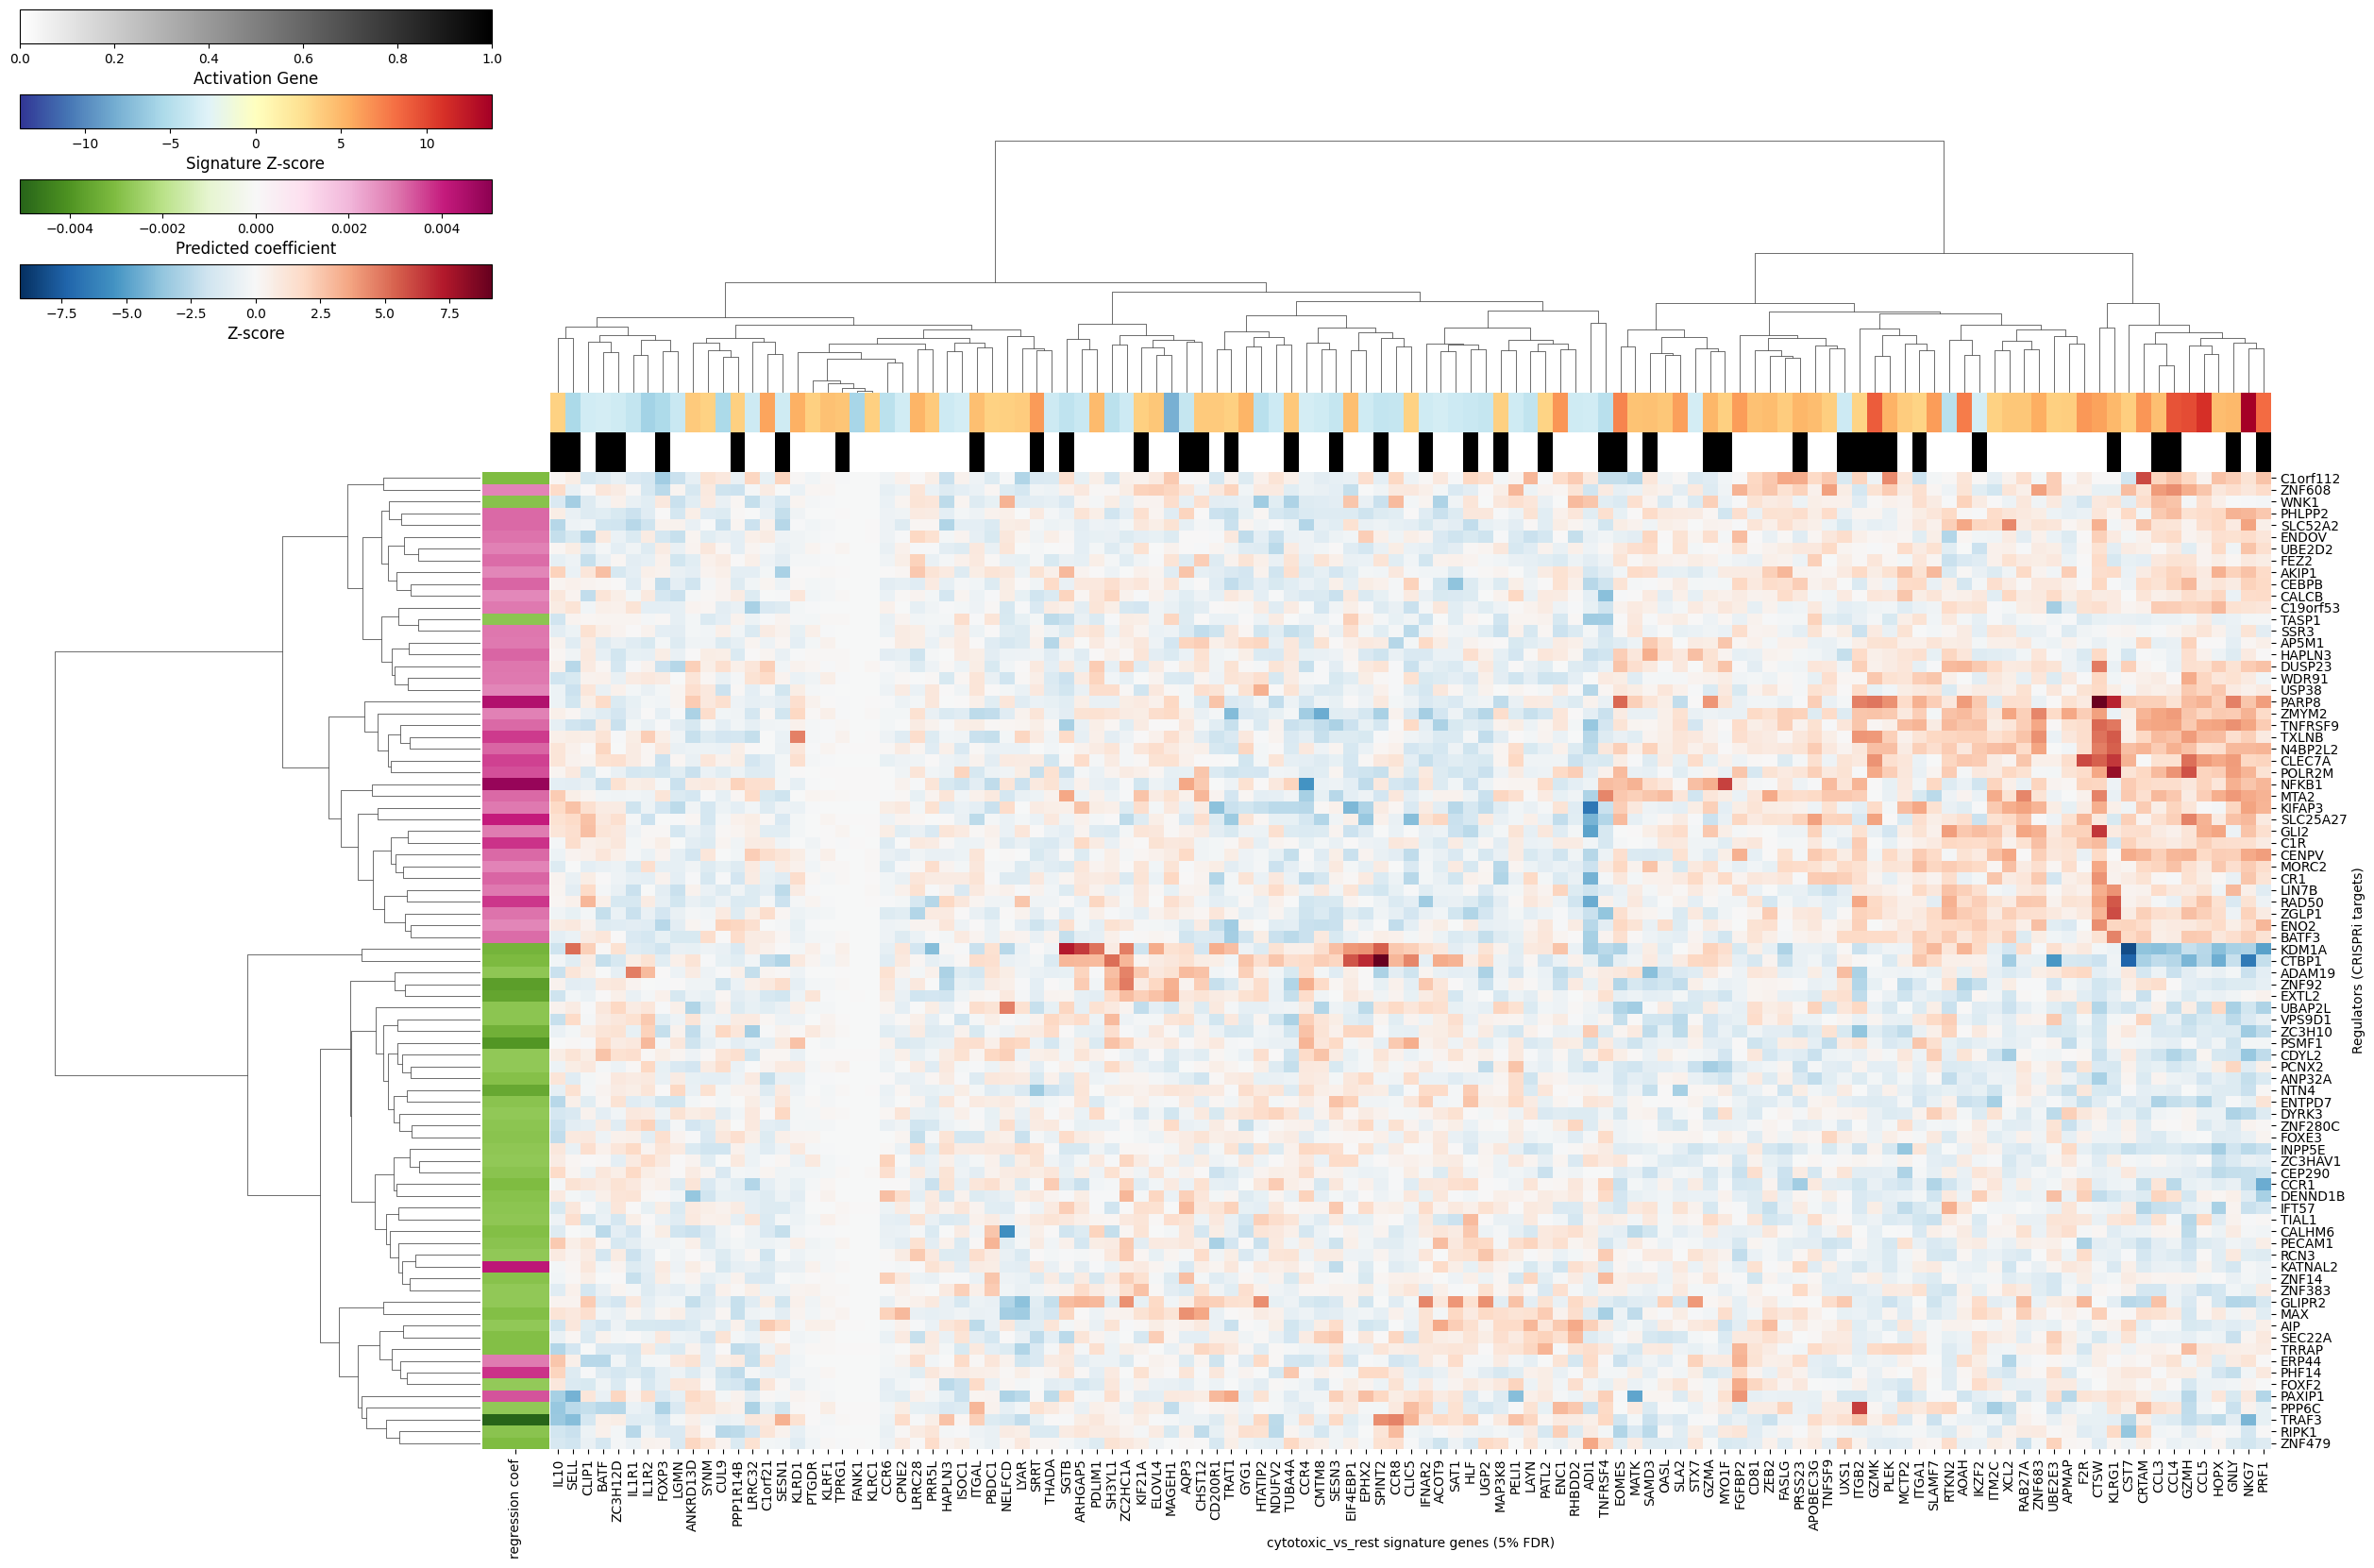

In [18]:
# Create row annotation dataframe with predicted effect sizes (now rows after transpose)
row_annot = pd.DataFrame({
    'regression coef': predicted_effect_size[wide_de_results.index]
})

# Create column annotation dataframe with signature zscores (now columns after transpose)
col_annot = pd.DataFrame({
    'zscore': signature_effect_size.set_index('variable').loc[wide_de_results.columns, 'zscore'],
    'activation_gene': signature_effect_size.set_index('variable').loc[wide_de_results.columns, 'activation_genes']
})

# Create different color maps for annotations
cmap_row = plt.cm.PiYG_r    # Pink-Yellow-Green for row annotation (predicted effect size)
cmap_col = plt.cm.RdYlBu_r  # Red-Yellow-Blue for column annotation (signature zscore)
cmap_activation = plt.cm.binary  # Binary colormap for activation genes

# Center the colormaps at 0 by using symmetric vmin/vmax
vmax_row = max(abs(row_annot['regression coef'].min()), abs(row_annot['regression coef'].max()))
vmax_col = max(abs(col_annot['zscore'].min()), abs(col_annot['zscore'].max()))
# Create color series for annotations (seaborn expects Series, not DataFrame with RGBA)
row_colors = row_annot['regression coef'].apply(lambda x: cmap_row((x + vmax_row) / (2 * vmax_row)))
col_colors = col_annot['zscore'].apply(lambda x: cmap_col((x + vmax_col) / (2 * vmax_col)))
activation_colors = col_annot['activation_gene'].apply(lambda x: cmap_activation(1.0 if x else 0.0))

# Create the clustermap
plt.figure(figsize=(30, 15))
g = sns.clustermap(wide_de_results,
                   cmap='RdBu_r',
                   center=0,
                   row_cluster=True,
                   col_cluster=True,
                   xticklabels=True,
                   yticklabels=True,
                   method='ward',
                   figsize=(25, 18),
                   row_colors=row_colors,
                   col_colors=[col_colors, activation_colors],
                   cbar_pos=None)

# Adjust layout to make room for additional colorbars
plt.subplots_adjust(top=0.85)

# Add colorbars for annotations - all same width and height
colorbar_width = 0.2
colorbar_height = 0.02
colorbar_left = 0

# Main heatmap colorbar - bottom
cbar_ax_main = g.fig.add_axes([colorbar_left, 0.75, colorbar_width, colorbar_height])
vmax_main = max(abs(wide_de_results.min().min()), abs(wide_de_results.max().max()))
sm_main = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-vmax_main, vmax=vmax_main))
sm_main.set_array([])
cbar_main = plt.colorbar(sm_main, cax=cbar_ax_main, orientation='horizontal')
cbar_main.set_label('Z-score', fontsize=12)

# Row annotation colorbar (predicted effect size)
cbar_ax_row = g.fig.add_axes([colorbar_left, 0.80, colorbar_width, colorbar_height])
sm_row = plt.cm.ScalarMappable(cmap=cmap_row, norm=plt.Normalize(vmin=-vmax_row, vmax=vmax_row))
sm_row.set_array([])
cbar_row = plt.colorbar(sm_row, cax=cbar_ax_row, orientation='horizontal')
cbar_row.set_label('Predicted coefficient', fontsize=12)

# Column annotation colorbar (signature zscore)
cbar_ax_col = g.fig.add_axes([colorbar_left, 0.85, colorbar_width, colorbar_height])
sm_col = plt.cm.ScalarMappable(cmap=cmap_col, norm=plt.Normalize(vmin=-vmax_col, vmax=vmax_col))
sm_col.set_array([])
cbar_col = plt.colorbar(sm_col, cax=cbar_ax_col, orientation='horizontal')
cbar_col.set_label('Signature Z-score', fontsize=12)

# Activation gene colorbar
cbar_ax_activation = g.fig.add_axes([colorbar_left, 0.90, colorbar_width, colorbar_height])
sm_activation = plt.cm.ScalarMappable(cmap=cmap_activation, norm=plt.Normalize(vmin=0, vmax=1))
sm_activation.set_array([])
cbar_activation = plt.colorbar(sm_activation, cax=cbar_ax_activation, orientation='horizontal')
cbar_activation.set_label('Activation Gene', fontsize=12)
cbar_col.set_label('Signature Z-score', fontsize=12)

# Rotate x-axis labels
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center')

plt.show()

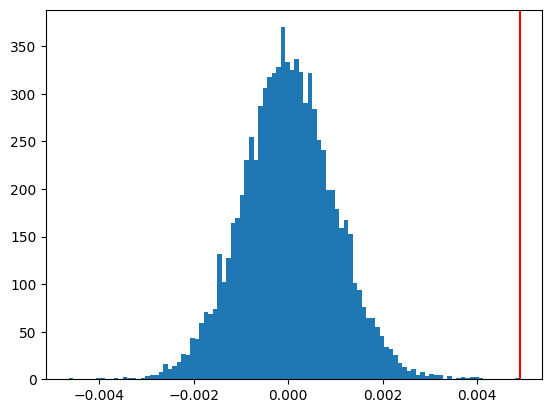

In [275]:
plt.hist(all_coefs['coef_mean'], bins=100);
plt.axvline(all_coefs.loc['NFKB1']['coef_mean'], color='red');

In [32]:
top_10_percent

NFKB1       0.004895
PARP8       0.004436
KATNAL2     0.004196
SLC25A27    0.004059
STAT5B      0.003878
C1R         0.003784
PHF14       0.003781
RAD50       0.003728
TXLNB       0.003695
CLEC7A      0.003615
POLR2M      0.003477
PAXIP1      0.003416
HAPLN3      0.003244
N4BP2L2     0.003242
CEBPB       0.003230
CR1         0.003219
SLC52A2     0.003210
TNFRSF9     0.003206
CENPV       0.003197
MTA2        0.003192
PHLPP2      0.003181
BATF3       0.003161
FEZ2        0.003135
ENDOV       0.003087
ZGLP1       0.003055
SSR3        0.003051
DUSP23      0.003051
LIN7B       0.002997
KIFAP3      0.002997
C19orf53    0.002995
AP5M1       0.002989
WDR91       0.002976
ERP44       0.002971
GLI2        0.002935
UBE2D2      0.002876
ZMYM2       0.002861
ZNF608      0.002848
MORC2       0.002837
USP38       0.002809
AKIP1       0.002795
ENO2        0.002783
CALCB       0.002776
Name: coef_mean, dtype: float64

Text(0.05, 0.95, 'r = 0.13')

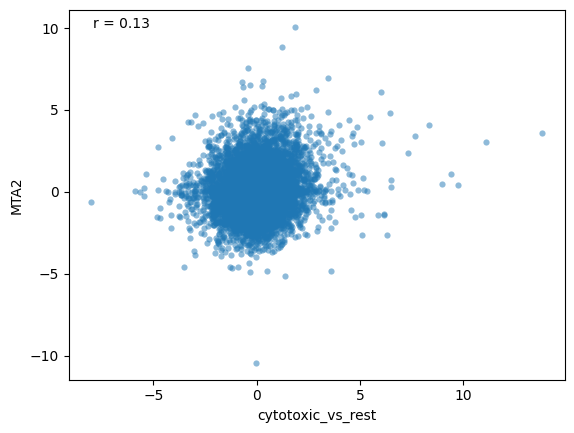

In [ ]:
r = 'BATF3'
# Calculate correlation coefficient
corr = np.corrcoef(y_target, X_perturbs[r])[0,1]

# Create scatter plot with smaller dots and no outline
sns.scatterplot(x=y_target, y=X_perturbs[r], s=20, linewidth=0, alpha=0.5)

# Add correlation coefficient to plot
plt.text(0.05, 0.95, f'r = {corr:.2f}', transform=plt.gca().transAxes)

Text(0.05, 0.95, 'r = 0.01')

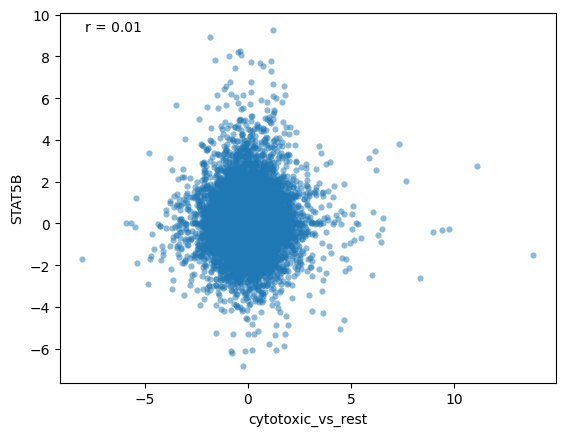

In [40]:
r = 'STAT5B'
# Calculate correlation coefficient
corr = np.corrcoef(y_target, X_perturbs[r])[0,1]

# Create scatter plot with smaller dots and no outline
sns.scatterplot(x=y_target, y=X_perturbs[r], s=20, linewidth=0, alpha=0.5)

# Add correlation coefficient to plot
plt.text(0.05, 0.95, f'r = {corr:.2f}', transform=plt.gca().transAxes)

### Check single-cell profiles for predicted regulators

In [19]:
st_coefs = all_coefs[all_coefs['state'] == 'cytotoxic_vs_rest'].copy()
top_10_percent = st_coefs['coef_mean'].nlargest(int(n * top_quant))

In [20]:
import sys
sys.path.append('..')
from utils import load_cells

In [55]:
sgrna_library_metadata = pd.read_csv('../../metadata/sgRNA_library_curated.csv', index_col=0)
reg_guides = sgrna_library_metadata[sgrna_library_metadata.perturbed_gene_name.isin(top_10_percent.index.tolist())]['sgrna_id'].tolist()
len(reg_guides)

84

In [56]:
h5ad_files = glob.glob('/mnt/oak/users/emma/data/GWT/CD4iR1_Psomagen' + '/tmp/CD4i_R1*Rest*.scRNA.postQC.h5ad')
obs_filt = {
    'guide_id':reg_guides + ['NTC-001', 'NTC-002', 'NTC-004', 'NTC-006', 'NTC-005','NTC-003', 'NTC-007', 'NTC-008']
}
adata_sc = load_cells(h5ad_files, obs_filt)

Reading files:   0%|          | 0/46 [00:00<?, ?it/s]

In [57]:
adata_sc

AnnData object with n_obs × n_vars = 17390 × 18114
    obs: 'library_id', 'lane_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'top_guide_UMI_counts', 'guide_id', 'sequence', 'perturbed_gene_name', 'perturbed_gene_id', 'guide_type', 'low_quality', 'target_lognorm_expr'
    var: 'gene_ids', 'gene_name'

In [58]:
adata_sc.var_names = adata_sc.var['gene_name'].values 

In [59]:
adata_sc.layers['counts'] = adata_sc.X.copy()

In [60]:
sc.pp.normalize_total(adata_sc)
sc.pp.log1p(adata_sc)

In [61]:
sc.pp.highly_variable_genes(adata_sc)

In [215]:
# Get top DE genes for input signature
state_results_df = cytotoxic_signature[cytotoxic_signature['contrast'] == 'cytotoxic_vs_rest']
signature_effect_size_up = state_results_df[(state_results_df['adj_p_value'] < 0.01) & (state_results_df['log_fc'] > 0)].sort_values('zscore')
signature_effect_size_down = state_results_df[(state_results_df['adj_p_value'] < 0.01) & (state_results_df['log_fc'] < 0)].sort_values('zscore')
signature_gs_up = signature_effect_size_up.variable.tolist()
signature_gs_down = signature_effect_size_down.variable.tolist()

confounder_key = 'donor_id'

# Calculate scores for up genes
score_df_up = sc.get.obs_df(adata_sc, np.intersect1d(signature_gs_up, adata_sc.var_names).tolist() + [confounder_key])
batch_mean_up = score_df_up.groupby(confounder_key).mean()
batch_std_up = score_df_up.groupby(confounder_key).std()

# Calculate scores for down genes  
score_df_down = sc.get.obs_df(adata_sc, np.intersect1d(signature_gs_down, adata_sc.var_names).tolist() + [confounder_key])
batch_mean_down = score_df_down.groupby(confounder_key).mean()
batch_std_down = score_df_down.groupby(confounder_key).std()

# Standardize values for each batch
for batch in score_df_up[confounder_key].unique():
    batch_mask = score_df_up[confounder_key] == batch
    genes_up = np.intersect1d(signature_gs_up, adata_sc.var_names).tolist()
    score_df_up.loc[batch_mask, genes_up] = ((score_df_up.loc[batch_mask, genes_up] - batch_mean_up.loc[batch, genes_up]) / batch_std_up.loc[batch, genes_up]).fillna(0)
    
    batch_mask = score_df_down[confounder_key] == batch
    genes_down = np.intersect1d(signature_gs_down, adata_sc.var_names).tolist()
    score_df_down.loc[batch_mask, genes_down] = ((score_df_down.loc[batch_mask, genes_down] - batch_mean_down.loc[batch, genes_down]) / batch_std_down.loc[batch, genes_down]).fillna(0)

# Calculate final scores    
adata_sc.obs['score_norm_up'] = score_df_up.drop('donor_id', axis=1).mean(axis=1)
adata_sc.obs['score_norm_down'] = score_df_down.drop('donor_id', axis=1).mean(axis=1)
adata_sc.obs['score_norm'] = adata_sc.obs['score_norm_up'] - adata_sc.obs['score_norm_down']

<Axes: xlabel='score_norm_up', ylabel='Count'>

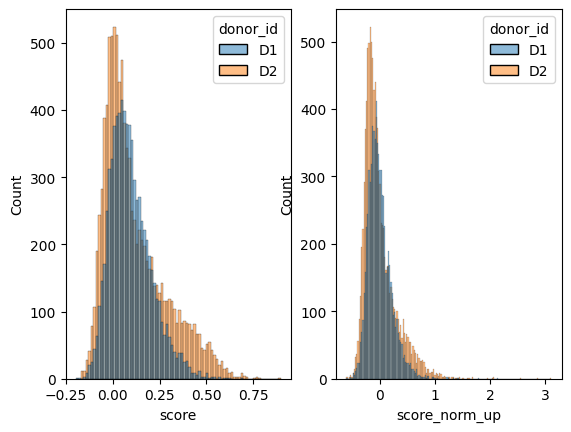

In [216]:
sc.tl.score_genes(adata_sc, signature_gs_up)
plt.subplot(1,2,1);
sns.histplot(data=adata_sc.obs, x='score', hue='donor_id');
plt.subplot(1,2,2);
sns.histplot(data=adata_sc.obs, x='score_norm_up', hue='donor_id')

In [217]:
adata_sc.obs['donor_id'] = adata_sc.obs_names.str.split("_").str[5]

/tmp/ipykernel_1885791/2302164513.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(gene_order, rotation=90)


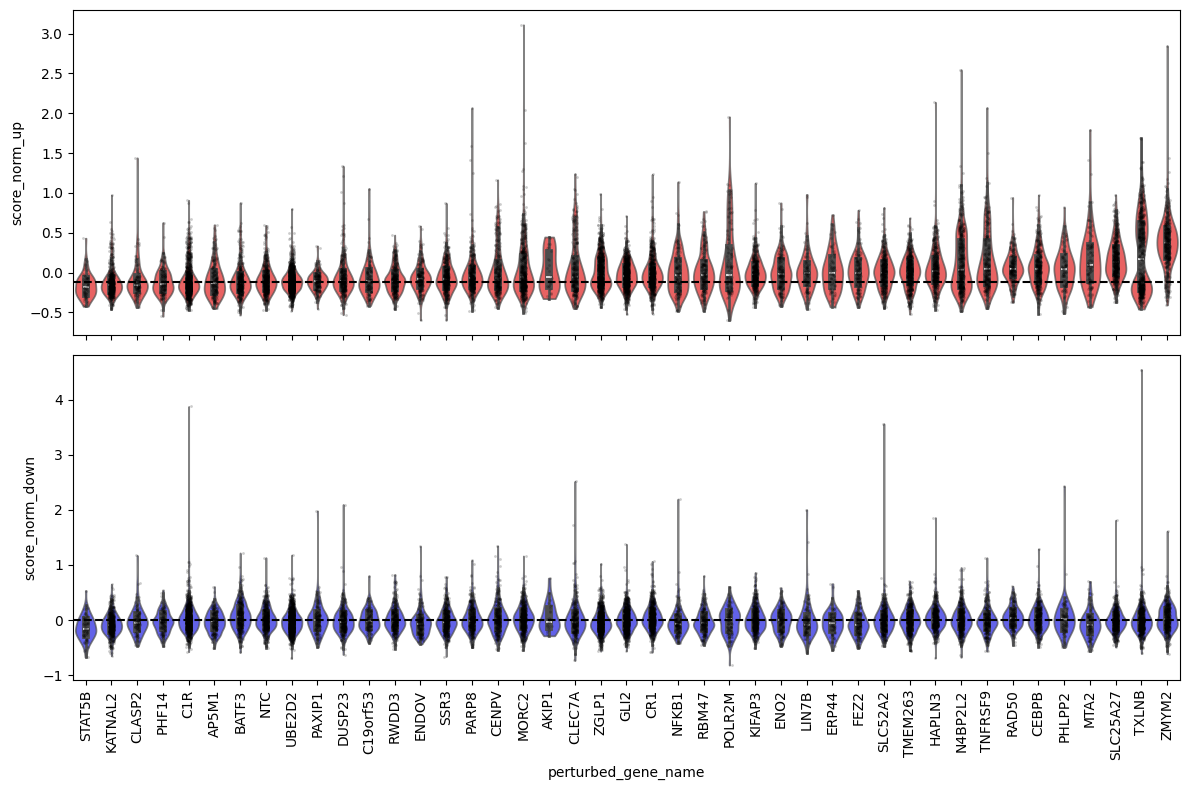

In [227]:
g = 'NKG7'
pl_df = sc.get.obs_df(adata_sc, ['score_norm_down', 'score_norm_up', 'donor_id', 'perturbed_gene_name'])

# Calculate median score_norm_up per perturbed gene and sort
gene_medians_up = pl_df.groupby('perturbed_gene_name')['score_norm_up'].median().sort_values()
gene_order = gene_medians_up.index.tolist()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot score_norm_up
sns.stripplot(data=pl_df, x='perturbed_gene_name', y='score_norm_up', color='black', alpha=0.2, s=2, order=gene_order, ax=ax1)
sns.violinplot(data=pl_df, x='perturbed_gene_name', y='score_norm_up', cut=0, alpha=0.7, order=gene_order, scale='width', color='red', ax=ax1)
ax1.axhline(gene_medians_up['NTC'], color='black', linestyle='--')
ax1.set_xticklabels([])

# Plot score_norm_down 
sns.stripplot(data=pl_df, x='perturbed_gene_name', y='score_norm_down', color='black', alpha=0.2, s=2, order=gene_order, ax=ax2)
sns.violinplot(data=pl_df, x='perturbed_gene_name', y='score_norm_down', cut=0, alpha=0.7, order=gene_order, scale='width', color='blue', ax=ax2)
ax2.axhline(pl_df.groupby('perturbed_gene_name')['score_norm_down'].median()['NTC'], color='black', linestyle='--')
ax2.set_xticklabels(gene_order, rotation=90)

plt.tight_layout()

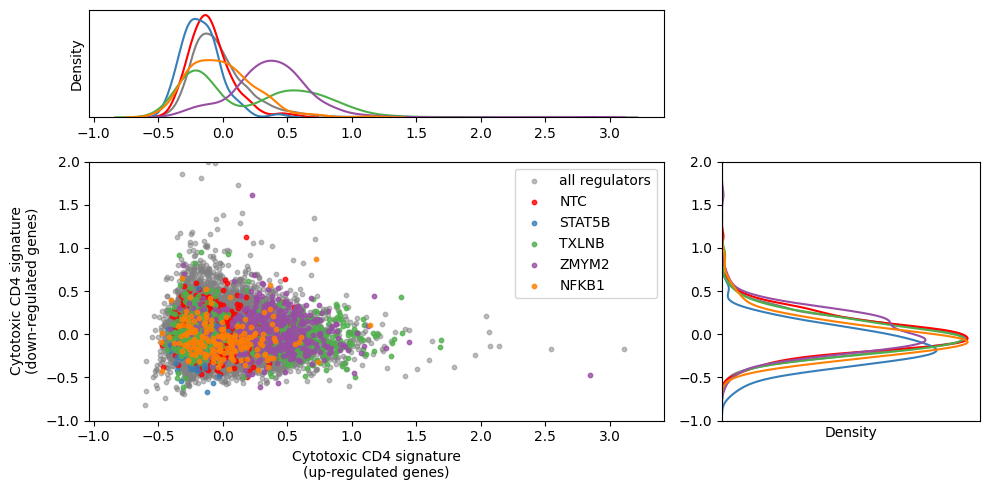

In [276]:
def plot_signature_scores(pl_df, highlight_genes, signature_name='state', figsize=(10,10), xlim=None, ylim=None):
    """
    Create scatter plot with marginal distributions of signature scores.
    
    Parameters:
    -----------
    pl_df : pandas.DataFrame
        DataFrame containing the signature scores and gene perturbation info
    highlight_genes : list
        List of gene names to highlight with different colors
    signature_name: str
        Name of signature for axis labels
    figsize : tuple, optional
        Figure size (width, height) in inches
    xlim : tuple, optional
        x-axis limits (min, max)
    ylim : tuple, optional 
        y-axis limits (min, max)
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure
    """
    # Create figure with gridspec for main scatter plot and marginal distributions
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 3)
    ax_main = fig.add_subplot(gs[1:, :-1])
    ax_right = fig.add_subplot(gs[1:, -1], sharey=ax_main)
    ax_top = fig.add_subplot(gs[0, :-1], sharex=ax_main)

    # Always include NTC in highlight genes
    if 'NTC' not in highlight_genes:
        highlight_genes = ['NTC'] + highlight_genes
        
    # Color palette for highlighted genes
    n_colors = len(highlight_genes)
    colors = sns.color_palette('Set1', n_colors=n_colors)
    
    # Create separate dataframes for highlighted genes and other points
    other_df = pl_df[~pl_df['perturbed_gene_name'].isin(highlight_genes)]
    
    # Plot other points first
    ax_main.scatter(other_df['score_norm_up'], other_df['score_norm_down'], 
                   s=10, color='grey', alpha=0.5, label='all regulators')
    sns.kdeplot(data=other_df, x='score_norm_up', color='grey', ax=ax_top)
    sns.kdeplot(data=other_df, y='score_norm_down', color='grey', ax=ax_right)
    
    # Plot highlighted genes
    for gene, color in zip(highlight_genes, colors):
        gene_df = pl_df[pl_df['perturbed_gene_name'] == gene]
        # Use red for NTC, otherwise use Set1 color
        plot_color = 'red' if gene == 'NTC' else color
        ax_main.scatter(gene_df['score_norm_up'], gene_df['score_norm_down'],
                       s=10, color=plot_color, alpha=0.8, label=gene)
        sns.kdeplot(data=gene_df, x='score_norm_up', color=plot_color, ax=ax_top)
        sns.kdeplot(data=gene_df, y='score_norm_down', color=plot_color, ax=ax_right)

    # Set axes properties
    ax_top.set_yticks([])
    ax_top.set_xlabel('')
    ax_right.set_xticks([])
    ax_right.set_ylabel('')
    
    # Set axis limits if provided
    if xlim is not None:
        ax_main.set_xlim(xlim)
        ax_top.set_xlim(xlim)
    if ylim is not None:
        ax_main.set_ylim(ylim)
        ax_right.set_ylim(ylim)
        
    ax_main.set_xlabel(f'{signature_name} signature\n(up-regulated genes)')
    ax_main.set_ylabel(f'{signature_name} signature\n(down-regulated genes)')
    ax_main.legend(bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    return fig

# Example usage:
highlight_genes = ['STAT5B', 'TXLNB', 'ZMYM2', 'NFKB1']
fig = plot_signature_scores(pl_df, highlight_genes, signature_name='Cytotoxic CD4', figsize=(10,5), ylim=(-1,2))

Some notes:
- TXLNB binds syntaxin proteins, which are part of the SNARE complex involved in exocytosis of vescicles. It's lowly expressed in T cells, which might explain the bimodal distribution.
- BATF3 has been shown to regulate cytotoxicity programs in CD8 T cells (https://www.nature.com/articles/s41588-023-01554-0)

In [ ]:
sc.pp.pca(adata_sc)

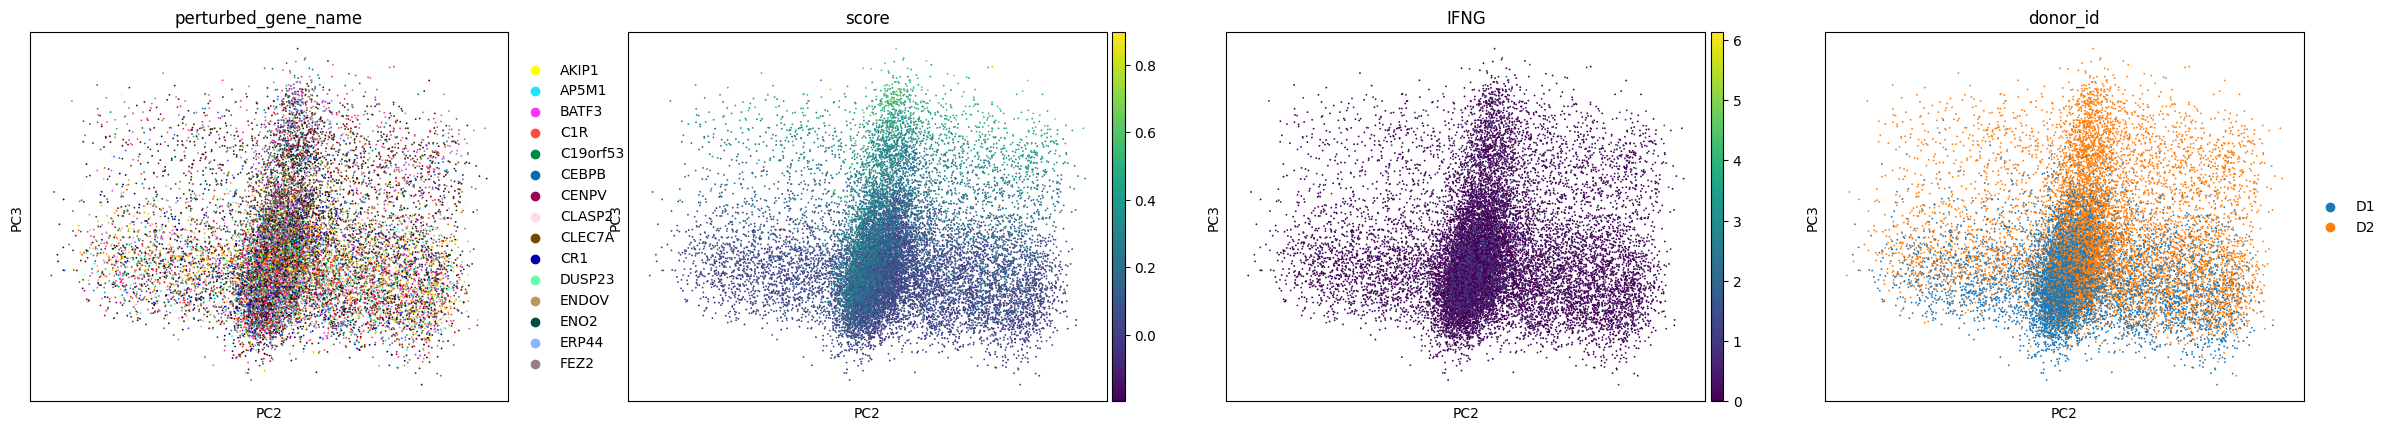

In [82]:
sc.pl.pca(adata_sc, color=['perturbed_gene_name', 'score', 'IFNG', 'donor_id'], components=['2,3'])

In [83]:
sc.pp.neighbors(adata_sc)
sc.tl.umap(adata_sc)

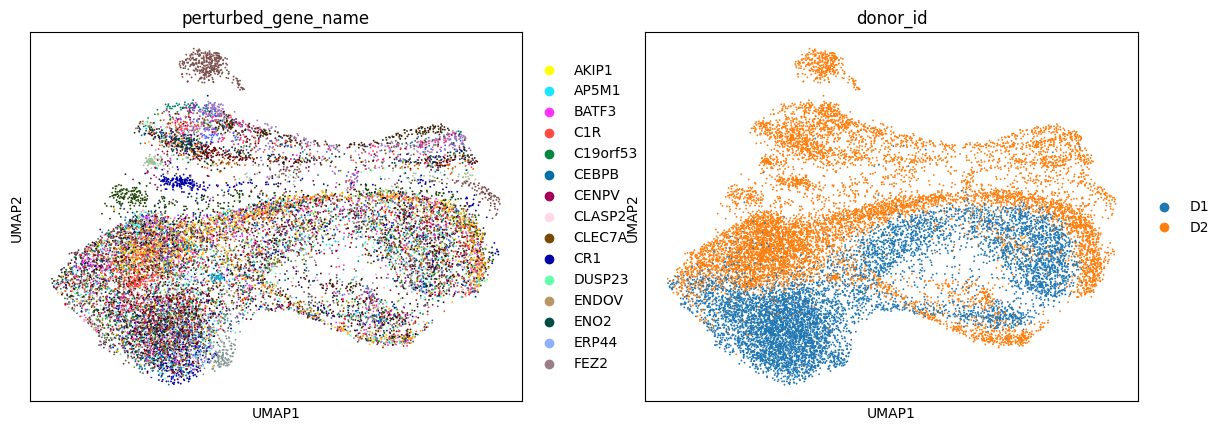

In [84]:
sc.pl.umap(adata_sc, color=['perturbed_gene_name','donor_id'])

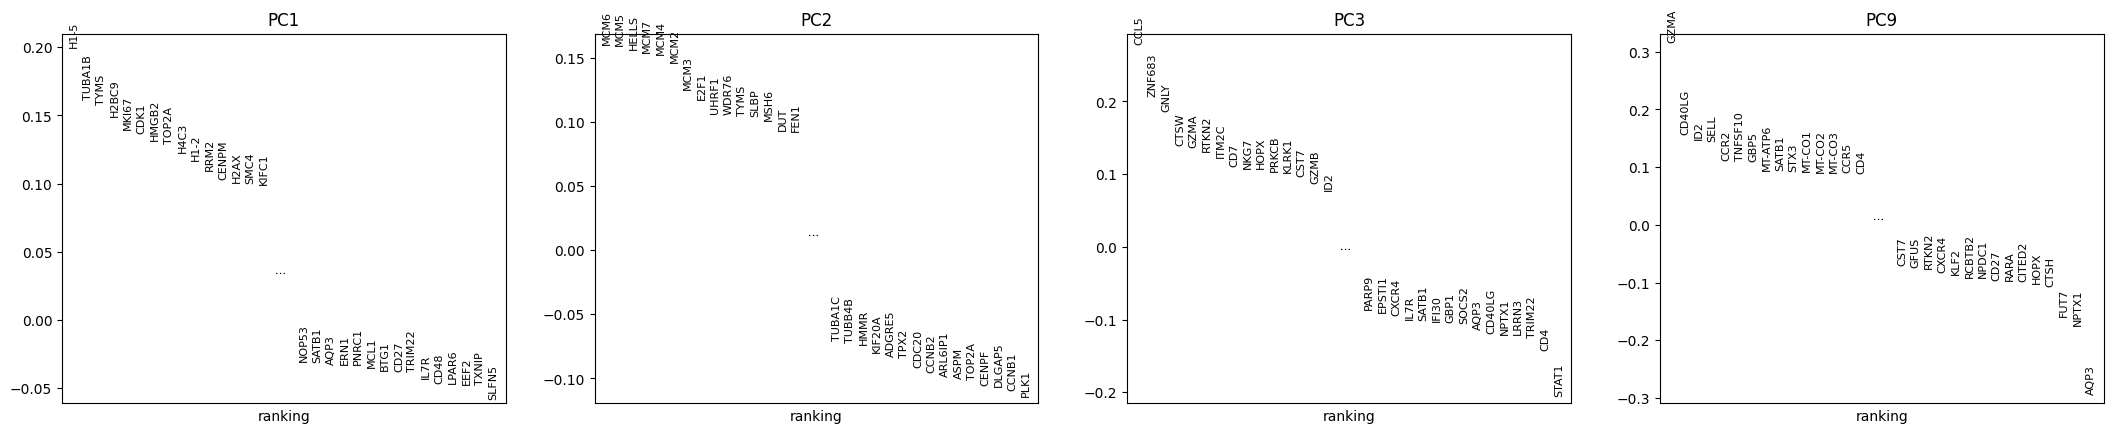

In [86]:
sc.pl.pca_loadings(adata_sc, components=[1,2,3, 9])

In [87]:
import scvi

In [200]:
scvi.model.SCVI.setup_anndata(adata_sc, layer="counts", batch_key="donor_id")
model = scvi.model.SCVI(adata_sc, n_layers=2, n_latent=30, gene_likelihood="nb")


In [201]:
model.train(max_epochs=50, check_val_every_n_epoch=10)


Trainer will use only 1 of 6 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=6)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/emmadann/miniforge3/envs/rpy2-voodoo/lib/pytho ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, pr

Training:   0%|          | 0/50 [00:00<?, ?it/s]

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=50` reached.


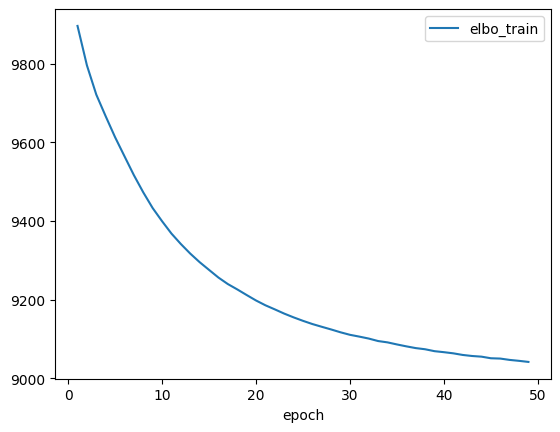

In [202]:
train_elbo = model.history["elbo_train"][1:]
# test_elbo = model.history["elbo_validation"]

ax = train_elbo.plot()
# test_elbo.plot(ax=ax)

In [203]:
adata_sc.obsm['X_scvi'] = model.get_latent_representation()

In [204]:
sc.pp.neighbors(adata_sc, use_rep='X_scvi')
sc.tl.umap(adata_sc)

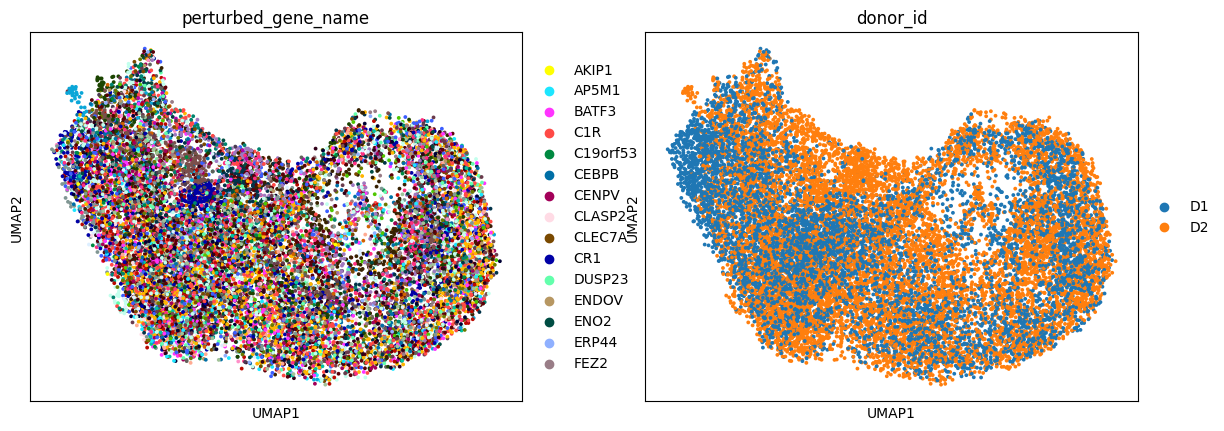

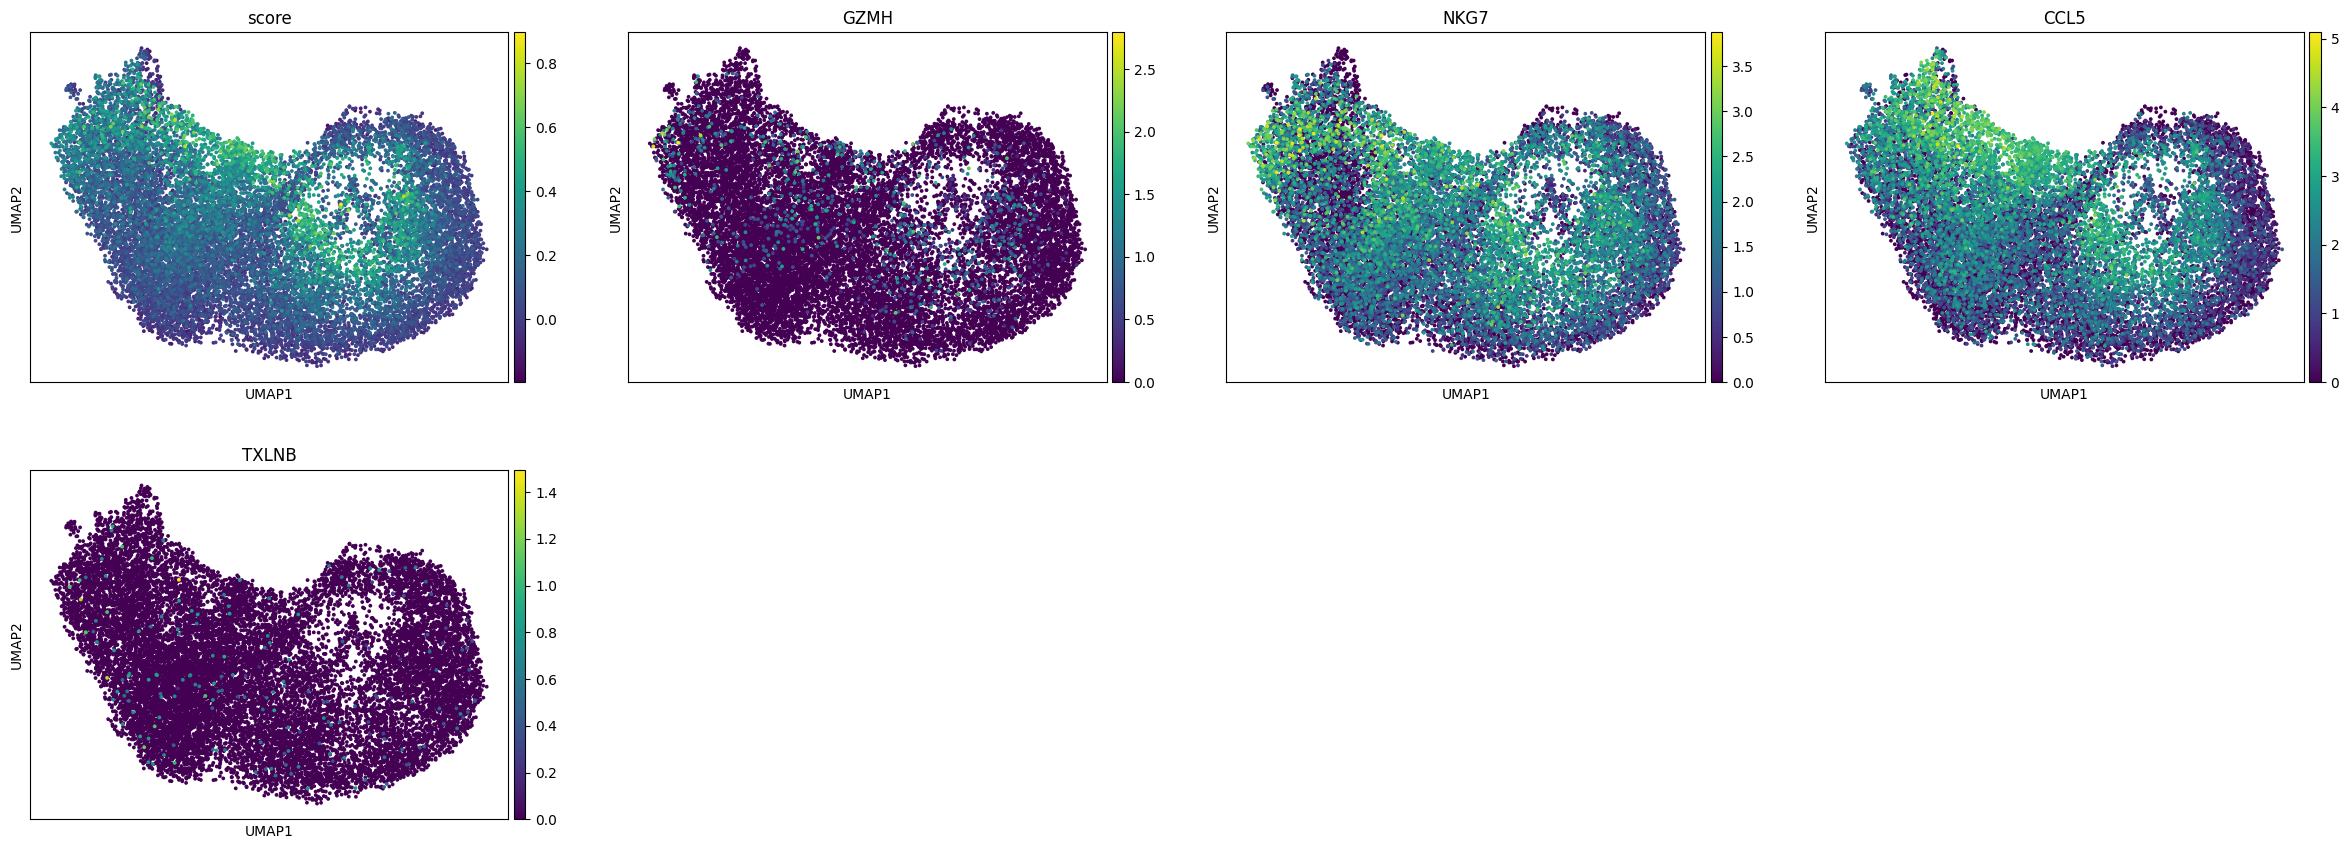

In [255]:
sc.pl.umap(adata_sc, color=['perturbed_gene_name', 'donor_id'],size=30)
sc.pl.umap(adata_sc, color=['score', 'GZMH', 'NKG7', 'CCL5', 'TXLNB'], size=30)

In [ ]:
top 

NameError: name 'top10_perc' is not defined

Index(['NFKB1', 'PARP8', 'SLC25A27', 'KATNAL2', 'PHF14', 'C1R', 'STAT5B',
       'RAD50', 'CLEC7A', 'TXLNB', 'POLR2M', 'N4BP2L2', 'CENPV', 'CEBPB',
       'MTA2', 'PHLPP2', 'BATF3', 'HAPLN3', 'FEZ2', 'SLC52A2', 'KIFAP3',
       'PAXIP1', 'TNFRSF9', 'AP5M1', 'DUSP23', 'ENDOV', 'C19orf53', 'LIN7B',
       'CR1', 'MORC2', 'RBM47', 'GLI2', 'CLASP2', 'ZGLP1', 'ENO2', 'UBE2D2',
       'SSR3', 'ERP44', 'ZMYM2', 'AKIP1', 'RWDD3', 'TMEM263'],
      dtype='object')

<Axes: >

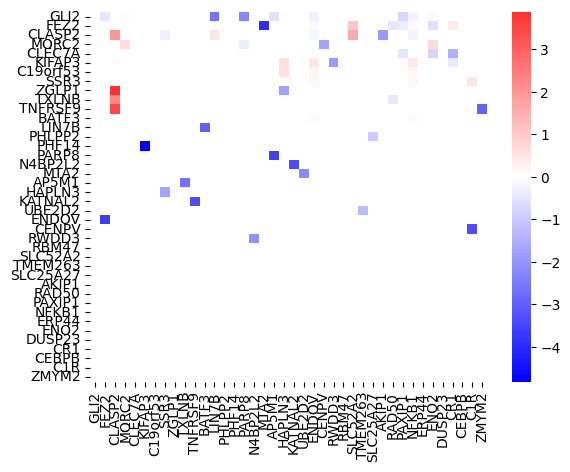

In [342]:
rest_adata_de = adata_de[adata_de.obs['culture_condition'] == 'Rest'].copy()
top_10_percent = st_coefs['coef_mean'].nlargest(int(n * top_quant))
bot_10_percent = st_coefs['coef_mean'].nsmallest(int(n * top_quant))

rest_adata_de = rest_adata_de[rest_adata_de.obs.target_contrast_gene_name.isin(np.intersect1d(top_10_percent.index, rest_adata_de.var_names)), np.intersect1d(top_10_percent.index, rest_adata_de.var_names)].copy()

effect_df = rest_adata_de.layers['log_fc']
signif_df = rest_adata_de.layers['adj_p_value']
effect_df[signif_df > 0.1] = 0

effect_df = pd.DataFrame(effect_df, index=rest_adata_de.var_names, columns=rest_adata_de.obs['target_contrast_gene_name'])

# Calculate mean number of outgoing connections for each gene
outgoing_connections = (abs(effect_df) > 0).mean(axis=1)

# Sort genes by outgoing connections
sorted_genes = outgoing_connections.sort_values(ascending=False).index

# Reorder rows and columns by sorted genes
effect_df = effect_df.loc[sorted_genes, sorted_genes]

sns.heatmap(effect_df, center=0, cmap='bwr', xticklabels=True, yticklabels=True)

In [343]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyBboxPatch

def plot_gene_network(matrix, gene_names=None, threshold=0.05, figsize=(12, 8)):
    """
    Plot a gene interaction network with genes ordered by outgoing connections.
    
    Parameters:
    -----------
    matrix : numpy.ndarray or pandas.DataFrame
        Square matrix where matrix[i,j] represents the effect of knocking out gene i on gene j
    gene_names : list, optional
        List of gene names. If None, will use G1, G2, etc.
    threshold : float, default=0.05
        Threshold for considering an interaction significant
    figsize : tuple, default=(12, 8)
        Figure size for the plot
    """
    
    # Convert to numpy array if DataFrame
    if isinstance(matrix, pd.DataFrame):
        if gene_names is None:
            gene_names = matrix.columns.tolist()
        matrix = matrix.values
    
    # Generate gene names if not provided
    if gene_names is None:
        gene_names = [f'G{i+1}' for i in range(matrix.shape[0])]
    
    n_genes = len(gene_names)
    
    # Create adjacency matrix based on threshold
    # Typically, you might want to exclude self-interactions (diagonal)
    adj_matrix = np.abs(matrix) > threshold
    np.fill_diagonal(adj_matrix, False)  # Remove self-loops
    
    # Calculate outgoing connections (how many genes each gene affects)
    outgoing_connections = np.sum(adj_matrix, axis=1)
    
    # Sort genes by outgoing connections (descending)
    sorted_indices = np.argsort(outgoing_connections)[::-1]
    sorted_genes = [gene_names[i] for i in sorted_indices]
    sorted_connections = outgoing_connections[sorted_indices]
    
    # Create the graph
    G = nx.DiGraph()
    
    # Add nodes with their connection counts
    for i, gene in enumerate(sorted_genes):
        G.add_node(gene, connections=sorted_connections[i])
    
    # Add edges based on the adjacency matrix
    for i in range(n_genes):
        for j in range(n_genes):
            if adj_matrix[sorted_indices[i], sorted_indices[j]]:
                source = sorted_genes[i]
                target = sorted_genes[j]
                weight = matrix[sorted_indices[i], sorted_indices[j]]
                G.add_edge(source, target, weight=weight)
    
    # Create layout - arrange nodes in columns by number of connections
    pos = {}
    
    # Group genes by their connection count
    connection_groups = {}
    for i, gene in enumerate(sorted_genes):
        conn_count = sorted_connections[i]
        if conn_count not in connection_groups:
            connection_groups[conn_count] = []
        connection_groups[conn_count].append(gene)
    
    # Sort connection counts in descending order
    unique_connections = sorted(connection_groups.keys(), reverse=True)
    
    # Position nodes
    for col_idx, conn_count in enumerate(unique_connections):
        genes_in_group = connection_groups[conn_count]
        n_genes_in_group = len(genes_in_group)
        
        # X position: same for all genes with same connection count
        x_pos = col_idx * 3  # Spacing between columns
        
        # Y positions: spread vertically within the column
        if n_genes_in_group == 1:
            y_positions = [0]
        else:
            y_positions = np.linspace(-1.5, 1.5, n_genes_in_group)
        
        for gene_idx, gene in enumerate(genes_in_group):
            pos[gene] = (x_pos, y_positions[gene_idx])
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, height_ratios=[4, 1])
    
    # Plot the network
    # Draw nodes with size proportional to outgoing connections
    node_sizes = [max(300, conn * 150) for conn in sorted_connections]
    node_colors = sorted_connections
    
    # Draw edges first (so they appear behind nodes)
    edge_weights = [abs(G[u][v]['weight']) for u, v in G.edges()]
    if edge_weights:  # Only draw edges if they exist
        max_weight = max(edge_weights) if edge_weights else 1
        normalized_weights = [w/max_weight for w in edge_weights]
        
        # Draw edges with different colors for positive/negative effects
        edge_colors = []
        for u, v in G.edges():
            weight = G[u][v]['weight']
            if weight > 0:
                edge_colors.append('red')
            else:
                edge_colors.append('blue')
        
        nx.draw_networkx_edges(G, pos, alpha=0.7, 
                              edge_color=edge_colors,
                              width=[max(0.5, w*3) for w in normalized_weights], 
                              arrows=True, arrowsize=20, 
                              arrowstyle='->', connectionstyle='arc3,rad=0.1',
                              ax=ax1)
    
    # Draw nodes on top
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                                  node_color=node_colors, cmap='viridis',
                                  alpha=0.9, linewidths=2, edgecolors='black',
                                  ax=ax1)
    
    # Draw labels with better positioning
    label_pos = {gene: (x, y-0.15) for gene, (x, y) in pos.items()}
    nx.draw_networkx_labels(G, label_pos, font_size=7, font_weight='bold', 
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8),
                           ax=ax1)
    
    ax1.set_title('Gene Interaction Network\n(Grouped by Outgoing Connections: Most → Least)\nRed edges: Positive effects, Blue edges: Negative effects', 
                 fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Set axis limits to ensure all nodes are visible
    if pos:
        x_coords = [x for x, y in pos.values()]
        y_coords = [y for x, y in pos.values()]
        ax1.set_xlim(min(x_coords) - 1, max(x_coords) + 1)
        ax1.set_ylim(min(y_coords) - 1.5, max(y_coords) + 1.5)
    
    # Add colorbar for node colors
    if nodes is not None:
        plt.colorbar(nodes, ax=ax1, label='Outgoing Connections', shrink=0.6)
    
    # Plot bar chart of connections
    bars = ax2.bar(range(len(sorted_genes)), sorted_connections, 
                  color=plt.cm.viridis(np.linspace(0, 1, len(sorted_genes))))
    ax2.set_xlabel('Genes (ordered by outgoing connections)')
    ax2.set_ylabel('Number of\nOutgoing Connections')
    ax2.set_xticks(range(len(sorted_genes)))
    ax2.set_xticklabels(sorted_genes, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, sorted_connections)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                str(int(val)), ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"Gene Network Summary:")
    print(f"Total genes: {n_genes}")
    print(f"Threshold used: {threshold}")
    print(f"Total connections: {G.number_of_edges()}")
    print(f"\nTop 5 genes by outgoing connections:")
    for i in range(min(5, len(sorted_genes))):
        print(f"{i+1}. {sorted_genes[i]}: {sorted_connections[i]} connections")
    
    return G, sorted_genes, sorted_connections

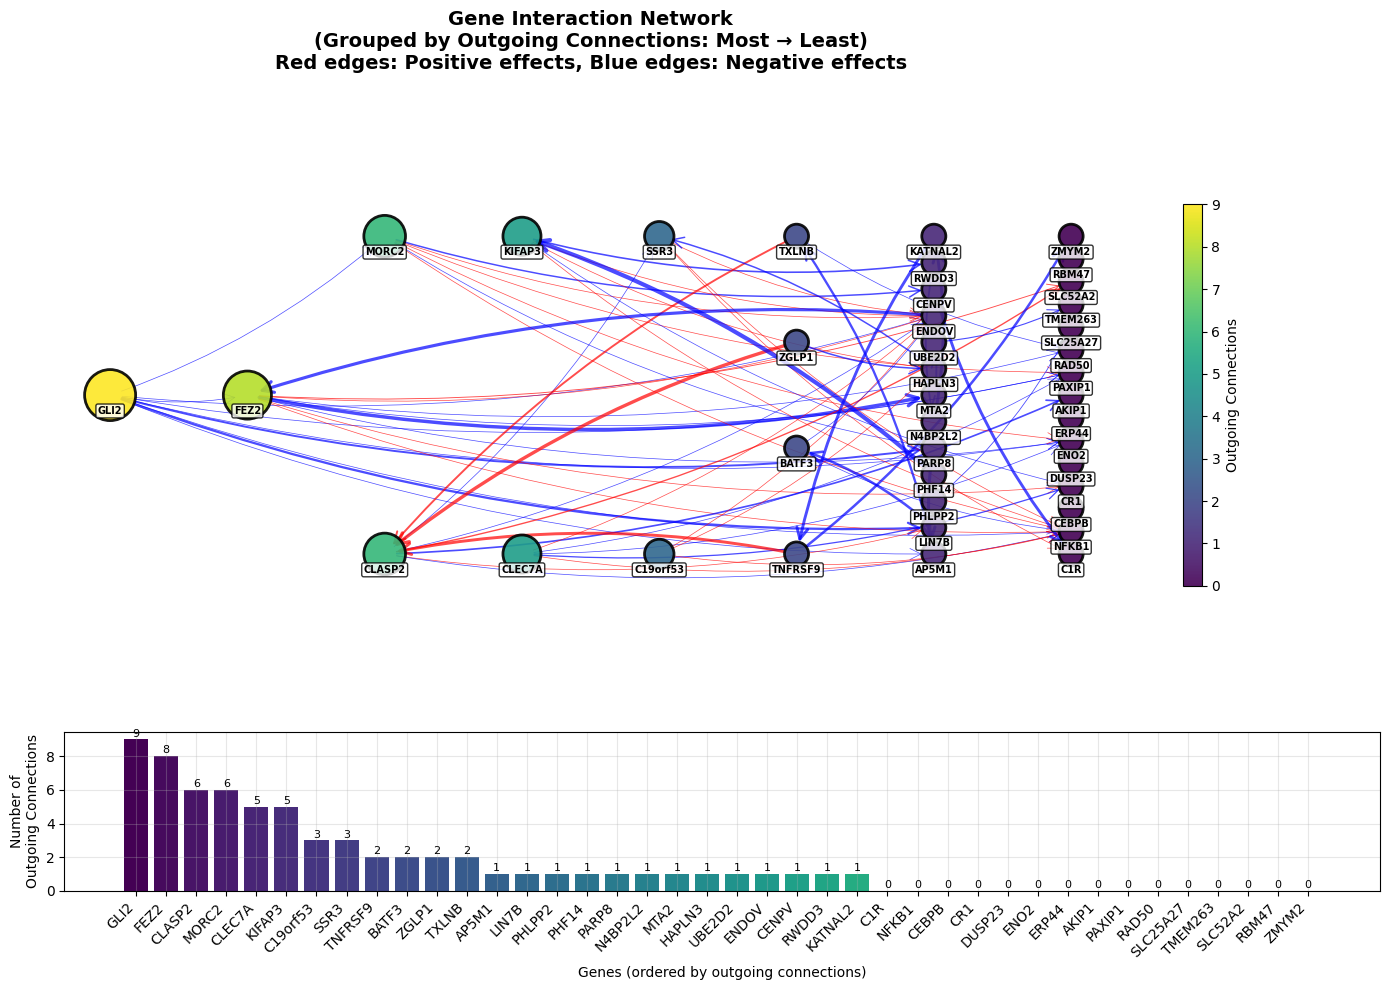

Gene Network Summary:
Total genes: 40
Threshold used: 0
Total connections: 66

Top 5 genes by outgoing connections:
1. GLI2: 9 connections
2. FEZ2: 8 connections
3. CLASP2: 6 connections
4. MORC2: 6 connections
5. CLEC7A: 5 connections


In [346]:
G, sorted_genes, connections = plot_gene_network(
        top_effect_df, 
        gene_names=top_effect_df.index, 
        threshold=0,
        figsize=(14, 10)
    )

In [277]:
get_DE_results_long(adata_de[adata_de.obs['culture_condition'] == 'Stim8hr'], targets=['NFKB1']).sort_values('adj_p_value')[0:50]

index      gene    log_fc    zscore   adj_p_value  \
5450   ENSG00000109320_Stim8hr     NFKB1 -1.172044 -9.954241  2.691111e-19   
1380   ENSG00000109320_Stim8hr      CD53  0.740041  7.200308  3.345075e-09   
5181   ENSG00000109320_Stim8hr      MUC1  1.887213  6.612481  1.402885e-07   
8263   ENSG00000109320_Stim8hr     SYTL3 -0.948973 -6.233437  1.270369e-06   
5230   ENSG00000109320_Stim8hr     MYO1F  1.894651  6.187265  1.363424e-06   
9041   ENSG00000109320_Stim8hr    TUBA1C -0.873620 -5.530990  5.910044e-05   
1331   ENSG00000109320_Stim8hr      CCR4 -1.789642 -5.440491  8.452832e-05   
8029   ENSG00000109320_Stim8hr    SQSTM1 -0.756459 -4.853851  1.493206e-03   
2367   ENSG00000109320_Stim8hr      DOK2 -0.595978 -4.833597  1.493206e-03   
5901   ENSG00000109320_Stim8hr      PBX4  1.138829  4.669457  3.057307e-03   
1140   ENSG00000109320_Stim8hr    CALHM2  1.568286  4.646085  3.100930e-03   
1173   ENSG00000109320_Stim8hr    CARD19  0.766900  4.574281  3.570761e-03   
6466   ENSG00000109320_Stim8hr      PPT1 -0.393726 -4.572919  3.570761e-03   
7782   ENSG00000109320_Stim8hr     SMAD3  0.775940  4.427111  6.256052e-03   
1403   ENSG00000109320_Stim8hr      CD99  0.485519  4.384326  7.197899e-03   
1706   ENSG00000109320_Stim8hr     CLIC3  2.771866  4.337536  8.445119e-03   
3360   ENSG00000109320_Stim8hr      GNG2  0.642667  4.259852  1.139004e-02   
7062   ENSG00000109320_Stim8hr     RIOK3  0.512382  4.227066  1.249499e-02   
9317   ENSG00000109320_Stim8hr       VDR -0.548270 -4.217663  1.249499e-02   
8745   ENSG00000109320_Stim8hr  TNFRSF1B  0.593663  4.117716  1.852674e-02   
1860   ENSG00000109320_Stim8hr     COTL1  0.600903  4.087561  1.941819e-02   
5878   ENSG00000109320_Stim8hr     PARP8  0.835299  4.094003  1.941819e-02   
3860   ENSG00000109320_Stim8hr     IFI16  0.323665  4.035879  2.243622e-02   
1194   ENSG00000109320_Stim8hr     CASS4  2.829493  4.010799  2.406713e-02   
8152   ENSG00000109320_Stim8hr      STK4  0.388421  3.918703  3.304676e-02   
10040  ENSG00000109320_Stim8hr     ZNRF3  1.733206  3.921333  3.304676e-02   
5738   ENSG00000109320_Stim8hr      OPTN  0.860068  3.910291  3.311521e-02   
5977   ENSG00000109320_Stim8hr     PDHA1  0.336045  3.824947  4.161694e-02   
6137   ENSG00000109320_Stim8hr      PIGN -0.596524 -3.839761  4.161694e-02   
4127   ENSG00000109320_Stim8hr      JAK2  0.566401  3.831572  4.161694e-02   
3141   ENSG00000109320_Stim8hr       FUZ  0.944241  3.828101  4.161694e-02   
6944   ENSG00000109320_Stim8hr    RCBTB2  1.425301  3.789094  4.677045e-02   
9433   ENSG00000109320_Stim8hr      WHRN  2.354870  3.766668  4.979311e-02   
7994   ENSG00000109320_Stim8hr    SPINK2  2.372515  3.731228  5.584083e-02   
8266   ENSG00000109320_Stim8hr      TAB3 -0.540490 -3.687843  6.457824e-02   
2936   ENSG00000109320_Stim8hr      FBRS -0.345548 -3.672628  6.683526e-02   
2767   ENSG00000109320_Stim8hr     EVA1B  1.306979  3.657097  6.928439e-02   
269    ENSG00000109320_Stim8hr      AKNA  0.412477  3.617907  6.979130e-02   
3952   ENSG00000109320_Stim8hr     IL23A -1.260673 -3.608039  6.979130e-02   
1005   ENSG00000109320_Stim8hr  C14orf28  1.437560  3.641314  6.979130e-02   
3464   ENSG00000109320_Stim8hr      GPX4  0.379022  3.629936  6.979130e-02   
6178   ENSG00000109320_Stim8hr   PITPNC1  0.930744  3.620205  6.979130e-02   
7771   ENSG00000109320_Stim8hr     SLFN5  1.093598  3.604247  6.979130e-02   
416    ENSG00000109320_Stim8hr     AP1S3 -0.894582 -3.609827  6.979130e-02   
6151   ENSG00000109320_Stim8hr    PIK3CG  0.675555  3.648780  6.979130e-02   
1650   ENSG00000109320_Stim8hr      CHUK -0.393037 -3.598104  6.999193e-02   
2401   ENSG00000109320_Stim8hr       DR1 -0.258475 -3.583766  7.205101e-02   
3448   ENSG00000109320_Stim8hr     GPR55  2.190544  3.580517  7.205101e-02   
9078   ENSG00000109320_Stim8hr    TXNDC5  0.268895  3.548236  7.576793e-02   
496    ENSG00000109320_Stim8hr    ARGLU1  0.298388  3.549527  7.576793e-02   

       significant gene_name culture_condition

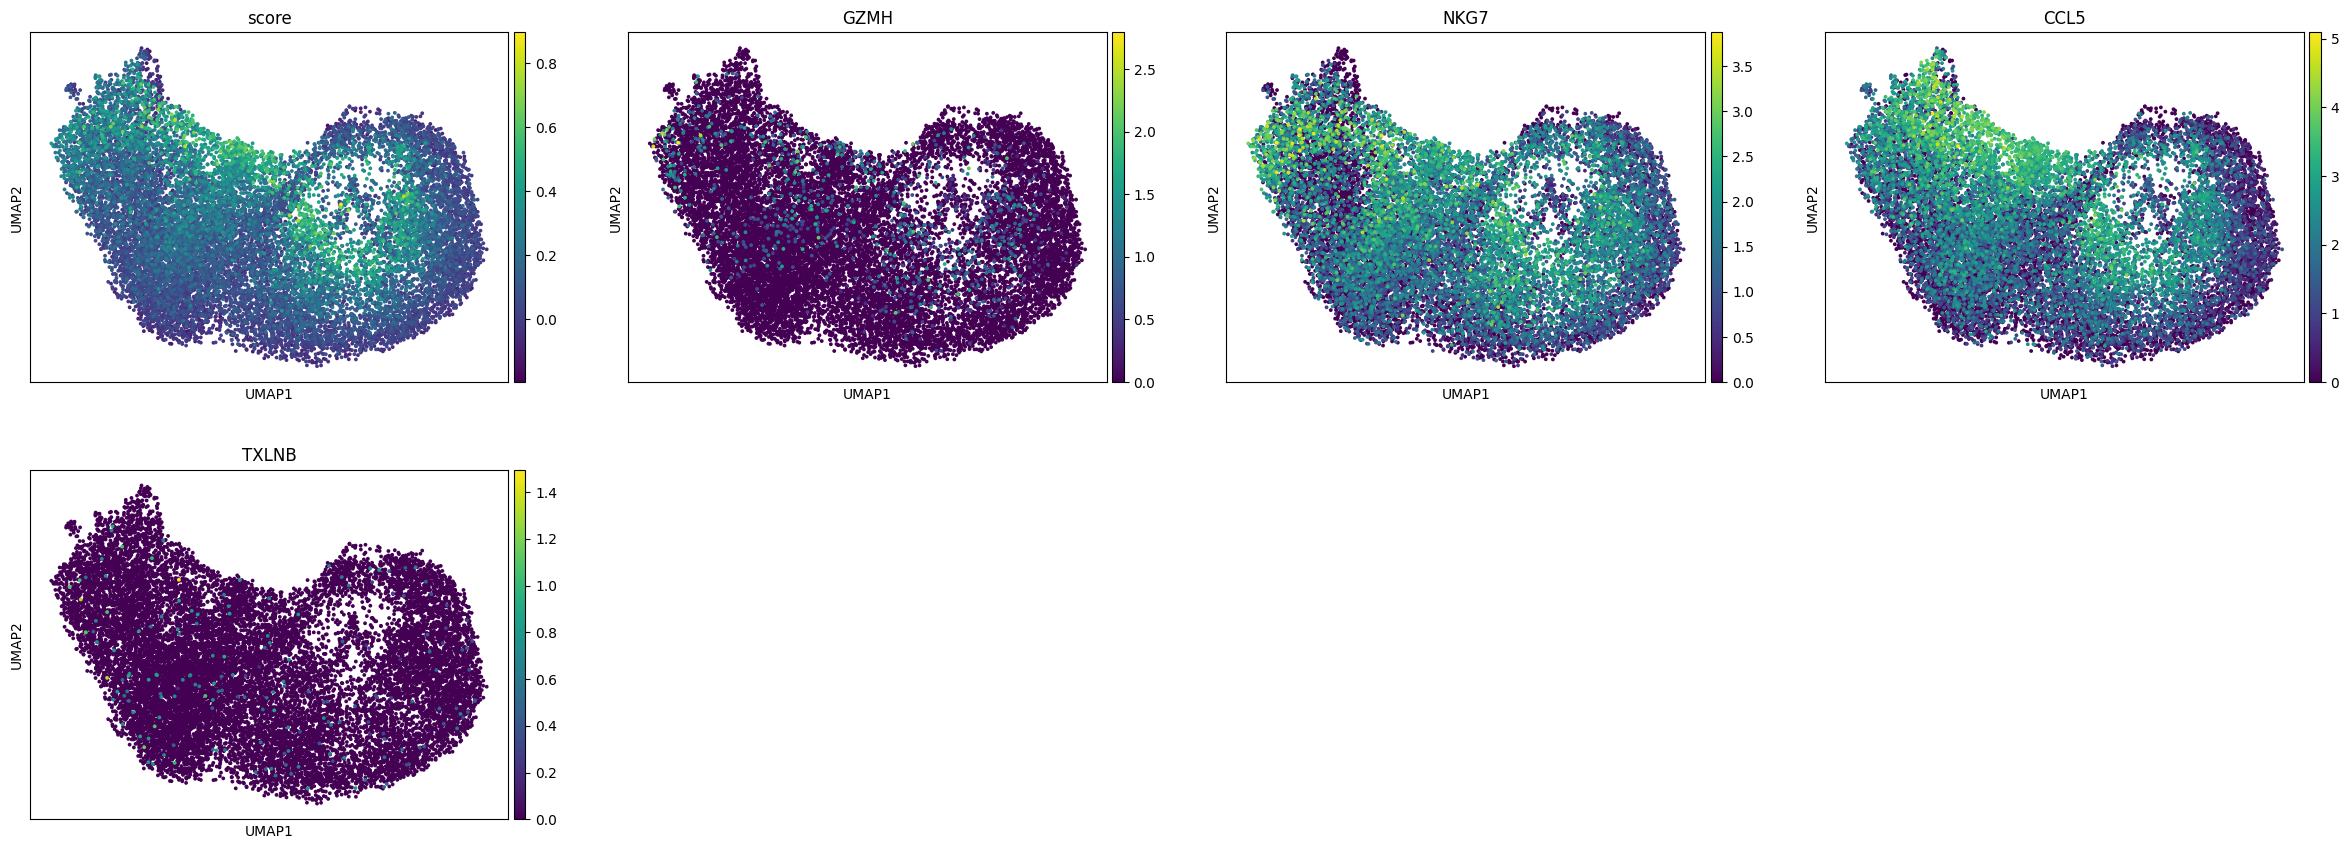

In [256]:
sc.pl.umap(adata_sc, color=['score', 'GZMH', 'NKG7', 'CCL5', 'TXLNB'], size=30)